<img src="New Project-2.jpg" width=300 height=500>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib as mpl
from scipy import stats as ss
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
%matplotlib inline
import plotly.express as px 



import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

In [2]:
df=pd.read_csv("EYAP_BAYI_SATIS.csv", encoding= "ISO-8859-9",sep=";")

In [3]:
df

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN
0,anon_S0,120.05.183,OLC2018000000145,2018.01.12,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,1150.56,1.0,A
1,anon_S2,120.12.TKV0246,AR52018000000146,2018.01.31,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,6240.00,5.0,A
2,anon_S0,120.15.510,EO12018000000545,2018.01.23,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,1342.80,1.0,A
3,anon_S2,120.SB.ANT2294,AR82018000000016,2018.01.03,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,2250.00,2.0,A
4,anon_S2,120.SB.LARA0088,AR82018000000006,2018.01.03,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,1230.00,1.0,A
...,...,...,...,...,...,...,...,...,...,...
30444,anon_S0,120.15.770,EO12020000009244,2020.11.07,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,3384.00,3.0,B
30445,anon_S2,120.SB.ISP2712,AR42020000001733,2020.11.12,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1488.00,1.0,B
30446,anon_S2,120.SB.ISP2724,AR42020000001792,2020.11.20,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1734.00,1.0,B
30447,anon_S2,120.SB.ANT3799,AR82020000003365,2020.11.09,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1817.40,1.0,B


Explanations:

* Yetkili Satıcı Kod: Yetkili satıcılar 3'e ayrılıyor. Anon_S0, Anon_S1, Anon_S2
* Müşteri Kod
* Matbuno
* Fatura Tarihi: Ürünlerin hangi tarihlerde alındığını gösteriyor.
* Hiyerarşi 1 
* Hiyerarşi 2
* Hiyerarşi 3
* Net Fiyat Sum
* Adet Sum : Kaç adet ürün alındığı veya iade edildiğini gösteriyor.
* Urun: Ürünler 3 gruba ayrılıyor. Sırasıyla A, B ve C ürünlerinde oluşuyor.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30449 entries, 0 to 30448
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Yetkili Satıcı Kod  30449 non-null  object 
 1   Müşteri Kod         30449 non-null  object 
 2   MatbuNo             30449 non-null  object 
 3   FaturaTarihi        30449 non-null  object 
 4   Hiyerarşi 1         30449 non-null  object 
 5   Hiyerarşi 2         30449 non-null  object 
 6   Hiyerarşi 3         30449 non-null  object 
 7   Net Fiyat_Sum       30449 non-null  float64
 8   Adet_Sum            30449 non-null  float64
 9   URUN                30449 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.3+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Net Fiyat_Sum,30449.0,3879.690018,7829.840045,-65408.4,1434.0,2448.3,4496.3388,478026.0
Adet_Sum,30449.0,1.478538,1.885659,-32.0,1.0,1.0,2.0000,125.0


# Functions

In [6]:
def average_price(df,products):
    df_sales=df[df['Adet_Sum']>0]
    for product in products:
        print(product,"mean price:", df_sales[df_sales['URUN']==product]['Net Fiyat_Sum'].sum()
              /df_sales[df_sales['URUN']==product]['Adet_Sum'].sum() )

def sale_number(df,products):
    df_sales=df[df['Adet_Sum']>0]
    for product in products:
        print(product,"was sold :",df_sales[df_sales['URUN']==product]['Adet_Sum'].sum(),"amount" )

def dealer_numbers(df,dealers):
    df_sales=df[df['Adet_Sum']>0]
    for dealer in dealers:
        print(dealer,"sold :",df_sales[df_sales['Yetkili Satıcı Kod']==dealer]['Adet_Sum'].sum(),"amount" )
        print(dealer,"sold :",df_sales[df_sales['Yetkili Satıcı Kod']==dealer]['Net Fiyat_Sum'].sum()," TL" )
        print("****************************************")
        
#dolar dataya kullanima hazir hale getiriliyor
def ort_kur(df):
    #ortalama hesapla
    return (df.loc[:,'Döviz Satış']+df.loc[:,'Döviz Alış'])/2


def df_ayar(df):
    #Oncelikle diger kurlari bi dusurelim.
    df = df.dropna(how = 'all')
    df.drop(df_dollars[df["Kur"]!="USD"].index,inplace = True)
    
    #Gereksiz columnlar atilsin
    df.drop(["Yayınlandığı Gün",'Yayınlandığı Tarih','Geçerli Olduğu Gün',"Yayınlandığı Tarih"
            ,"Yayınlandığı Gün","Geçerli Olduğu Gün","Döviz Alış",'Döviz Satış',"Kur"], axis=1,inplace = True)

    return df

# Feature Engineering

In [7]:
#Fatura tarihi, tarih formatında olmadığı için önce onu obje tipinden tarih tipine dönüştürelim.
df['FaturaTarihi'] = pd.to_datetime(df['FaturaTarihi'])

In [8]:
#ay, yil, gun, ay sonu, ay basi, mevsim ve yil baslangici gibi degerler feature olarak eklendi
df['month_year'] = df['FaturaTarihi'].apply(lambda x: x.strftime('%Y-%m'))
df["New_year"] = df['FaturaTarihi'].dt.year
df["New_month"] = df['FaturaTarihi'].dt.month
df["New_day"] = df['FaturaTarihi'].dt.day
df["New_dayofweek"] = df['FaturaTarihi'].dt.dayofweek
df["New_is_month_end"] = df['FaturaTarihi'].dt.is_month_end
df["New_is_month_start"] = df['FaturaTarihi'].dt.is_month_start
df["New_is_quarter_end"] = df['FaturaTarihi'].dt.is_quarter_end
df["New_is_quarter_start"] = df['FaturaTarihi'].dt.is_quarter_start
df["New_is_year_end"] = df['FaturaTarihi'].dt.is_year_end
df["New_is_year_start"] = df['FaturaTarihi'].dt.is_year_start
df['Weekday'] = df['FaturaTarihi'].dt.day_name()
df['MonthName'] = df['FaturaTarihi'].dt.month_name()

df['Season']=(df['FaturaTarihi'].dt.month%12+3)//3
Seasons={1: 'Winter', 2: 'Spring', 3:'Summer', 4: 'Autumn'}
df['SeasonName']=df['Season'].map(Seasons)

In [10]:
#Dolar kuru eklendi
df_dollars=pd.read_csv('dolar_kur.csv', parse_dates=[2], dayfirst=True)

#dolar datada kullanima hazir hale getiriliyor
df_dollars['Dolar_Kur']=ort_kur(df_dollars)
df_dollars=df_ayar(df_dollars)

df_dollars = df_dollars.rename(columns={'Geçerli Olduğu Tarih': 'FaturaTarihi'})
df=df.merge(df_dollars, on="FaturaTarihi",how='left')

#ozel gunler eklendi
special_days = pd.read_excel("Ozel Gunler.xlsx")
special_days = special_days.rename(columns={'Ozel_Gun_Tarihi': 'FaturaTarihi'})
df=df.merge(special_days, on=["FaturaTarihi"],how='left')

#ozel gunlerde nan olan degerler regular day olarak degistirildi
null_mask = df.loc[:,'Gun_Tanm'].isnull()
df.loc[null_mask,'Gun_Tanm'] = 'Regular Day'

#perakande satis endeksi
sale_index=pd.read_excel("sale_index.xlsx")
sale_index = sale_index.rename(columns={'year': 'New_year','month': 'New_month'})
df=df.merge(sale_index, on=["New_year",'New_month'],how='left')

#tufe
tufe=pd.read_excel("tufe.xlsx")
tufe = tufe.rename(columns={'year': 'New_year','month': 'New_month'})
df=df.merge(tufe, on=["New_year",'New_month'],how='left')

#ufe
ufe=pd.read_excel("ufe.xlsx")
ufe = ufe.rename(columns={'year': 'New_year','month': 'New_month'})
df=df.merge(ufe, on=["New_year",'New_month'],how='left')

In [11]:
df

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
0,anon_S0,120.05.183,OLC2018000000145,2018-01-12,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,1150.56,1.0,A,...,False,Friday,January,1,Winter,3.79535,Regular Day,97.528384,330.75,319.60
1,anon_S2,120.12.TKV0246,AR52018000000146,2018-01-31,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,6240.00,5.0,A,...,False,Wednesday,January,1,Winter,3.78290,Regular Day,97.528384,330.75,319.60
2,anon_S0,120.15.510,EO12018000000545,2018-01-23,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,1342.80,1.0,A,...,False,Tuesday,January,1,Winter,3.81325,Regular Day,97.528384,330.75,319.60
3,anon_S2,120.SB.ANT2294,AR82018000000016,2018-01-03,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,2250.00,2.0,A,...,False,Wednesday,January,1,Winter,3.76855,Regular Day,97.528384,330.75,319.60
4,anon_S2,120.SB.LARA0088,AR82018000000006,2018-01-03,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,1230.00,1.0,A,...,False,Wednesday,January,1,Winter,3.76855,Regular Day,97.528384,330.75,319.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30444,anon_S0,120.15.770,EO12020000009244,2020-11-07,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,3384.00,3.0,B,...,False,Saturday,November,4,Autumn,8.46890,Regular Day,127.058653,498.58,555.18
30445,anon_S2,120.SB.ISP2712,AR42020000001733,2020-11-12,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1488.00,1.0,B,...,False,Thursday,November,4,Autumn,8.05495,Regular Day,127.058653,498.58,555.18
30446,anon_S2,120.SB.ISP2724,AR42020000001792,2020-11-20,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1734.00,1.0,B,...,False,Friday,November,4,Autumn,7.67680,Regular Day,127.058653,498.58,555.18
30447,anon_S2,120.SB.ANT3799,AR82020000003365,2020-11-09,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1817.40,1.0,B,...,False,Monday,November,4,Autumn,8.46890,Regular Day,127.058653,498.58,555.18


# EDA

<AxesSubplot:xlabel='New_year', ylabel='Net Fiyat_Sum'>

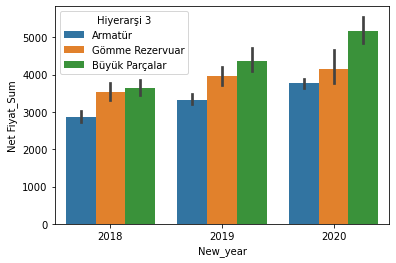

In [12]:
sns.barplot(x="New_year", y="Net Fiyat_Sum", hue="Hiyerarşi 3", data=df)

<AxesSubplot:xlabel='URUN', ylabel='Net Fiyat_Sum'>

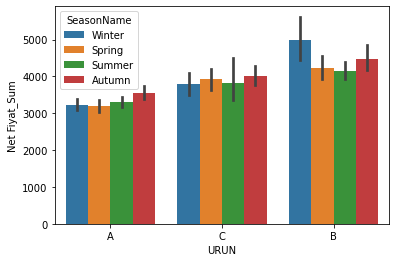

In [13]:
sns.barplot(x="URUN", y="Net Fiyat_Sum", hue="SeasonName", data=df)

<AxesSubplot:xlabel='New_year', ylabel='Net Fiyat_Sum'>

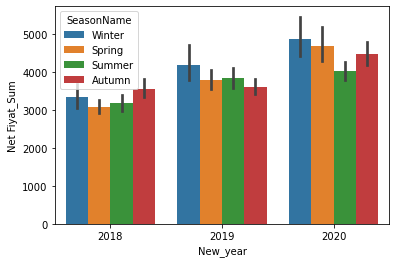

In [14]:
sns.barplot(x="New_year", y="Net Fiyat_Sum", hue="SeasonName", data=df)

<AxesSubplot:xlabel='URUN', ylabel='Net Fiyat_Sum'>

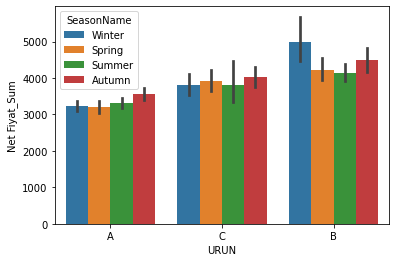

In [15]:
sns.barplot(x="URUN", y="Net Fiyat_Sum", hue="SeasonName", data=df)

<AxesSubplot:xlabel='URUN', ylabel='Adet_Sum'>

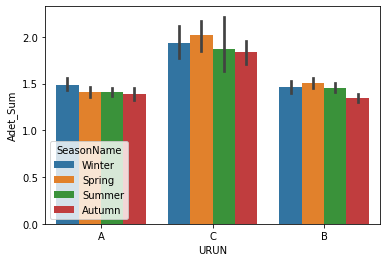

In [16]:
sns.barplot(x="URUN", y="Adet_Sum", hue="SeasonName", data=df)

<AxesSubplot:xlabel='Yetkili Satıcı Kod', ylabel='Adet_Sum'>

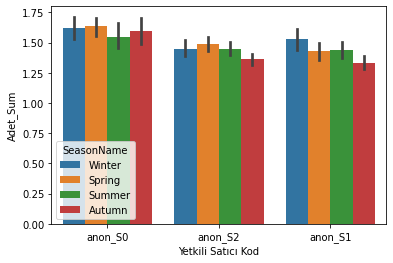

In [17]:
sns.barplot(x="Yetkili Satıcı Kod", y="Adet_Sum", hue="SeasonName", data=df)

<AxesSubplot:xlabel='New_year', ylabel='Adet_Sum'>

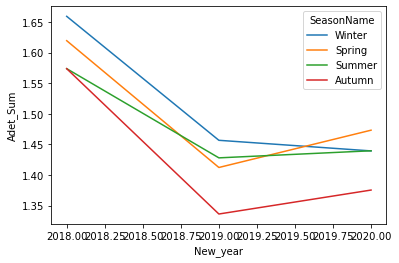

In [18]:
sns.lineplot(data=df, x="New_year", y="Adet_Sum", hue="SeasonName",ci=None)

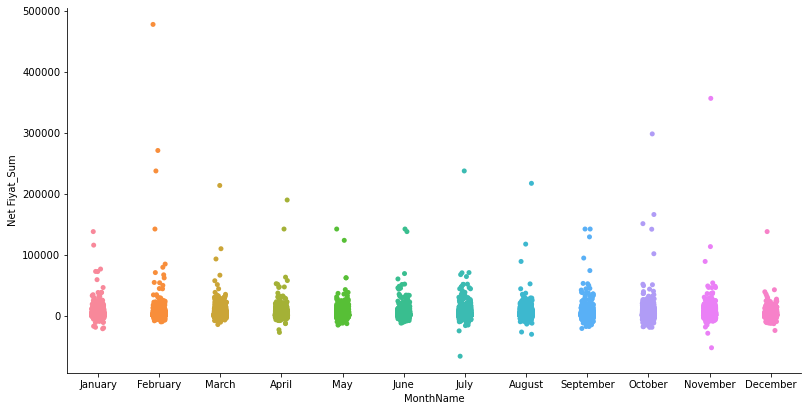

In [19]:
g = sns.catplot(data=df, x='MonthName', y='Net Fiyat_Sum')
g.fig.set_figwidth(13.10)
g.fig.set_figheight(5.7)

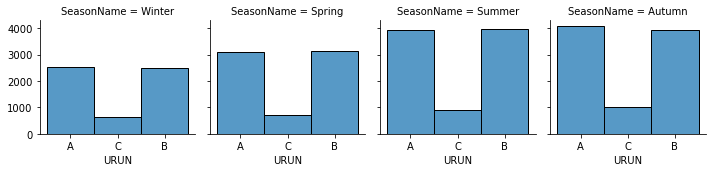

In [20]:
g = sns.FacetGrid(df, col="SeasonName", height=2.5, col_wrap=4)
g.map(sns.histplot, "URUN")

<AxesSubplot:xlabel='Net Fiyat_Sum', ylabel='MonthName'>

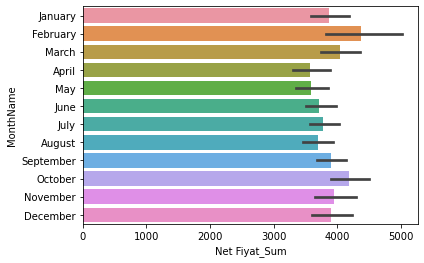

In [21]:
sns.barplot(x="Net Fiyat_Sum", y="MonthName", data=df)

In [22]:
#Yil ve aylara gore satis grafikleri
df_temp = df.groupby(['New_month',"New_year"]).sum()[['Net Fiyat_Sum',"Adet_Sum"]].reset_index()

In [23]:
df_temp

,New_month,New_year,Net Fiyat_Sum,Adet_Sum
0,1,2018,2.386319e+06,1232.0
1,1,2019,2.438543e+06,1020.0
2,1,2020,2.932910e+06,894.0
3,2,2018,2.513155e+06,1335.0
4,2,2019,2.616992e+06,831.0
5,2,2020,4.424289e+06,1271.0
6,3,2018,3.497127e+06,1650.0
7,3,2019,2.400965e+06,867.0
8,3,2020,3.874419e+06,1224.0
9,4,2018,2.919486e+06,1630.0


<AxesSubplot:xlabel='New_month', ylabel='Adet_Sum'>

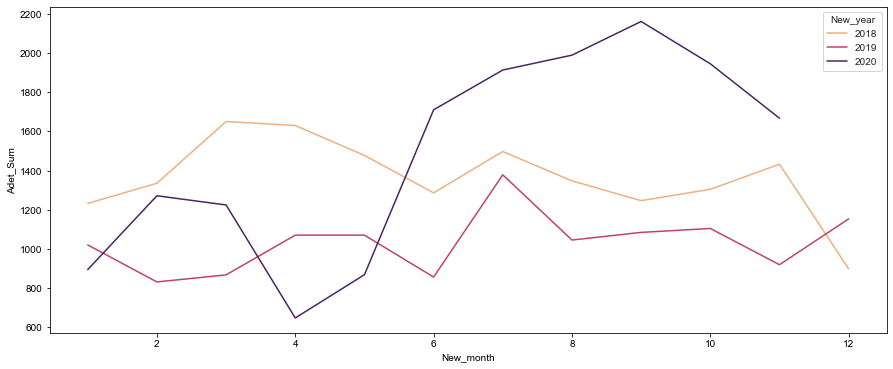

In [24]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df_temp,  
             x='New_month',  
             y='Adet_Sum',  
             hue='New_year', 
             legend='full',palette="flare",ci=None) 

<AxesSubplot:xlabel='New_month', ylabel='Net Fiyat_Sum'>

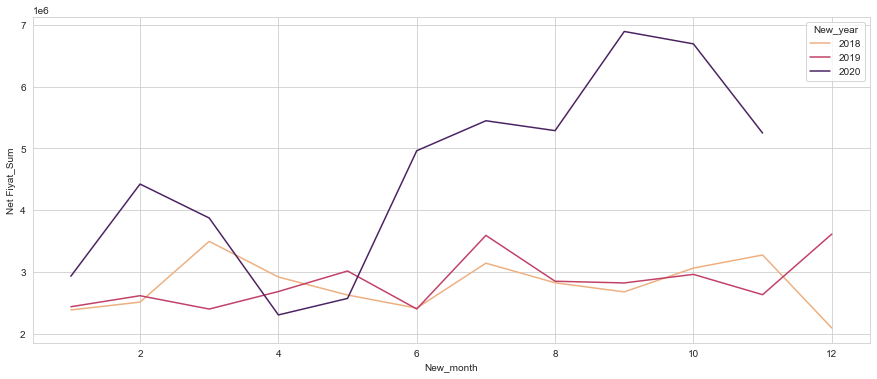

In [25]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df_temp,  
             x='New_month',  
             y='Net Fiyat_Sum',  
             hue='New_year', 
             legend='full',palette="flare",ci=None) 

<AxesSubplot:xlabel='Season', ylabel='Adet_Sum'>

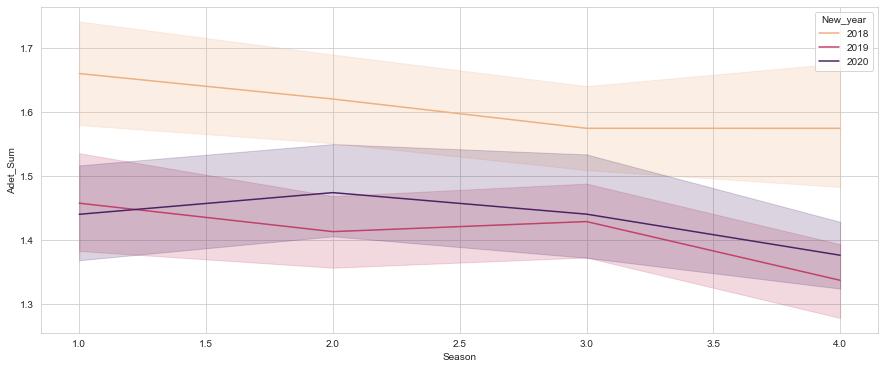

In [26]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df,  
             x='Season',  
             y='Adet_Sum',  
             hue='New_year', 
             legend='full',palette="flare") 

<AxesSubplot:xlabel='Season', ylabel='Net Fiyat_Sum'>

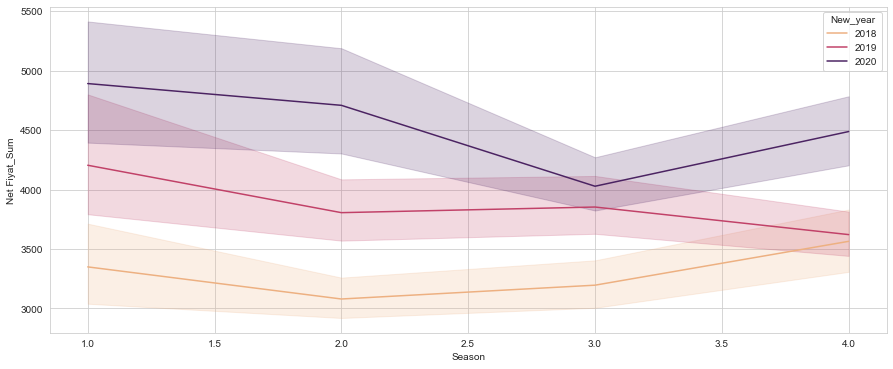

In [27]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df,  
             x='Season',  
             y='Net Fiyat_Sum',  
             hue='New_year', 
             legend='full',palette="flare") 

In [28]:
# grouping month_year by revenue
df_temp = df.groupby('month_year').sum()['Net Fiyat_Sum'].reset_index()

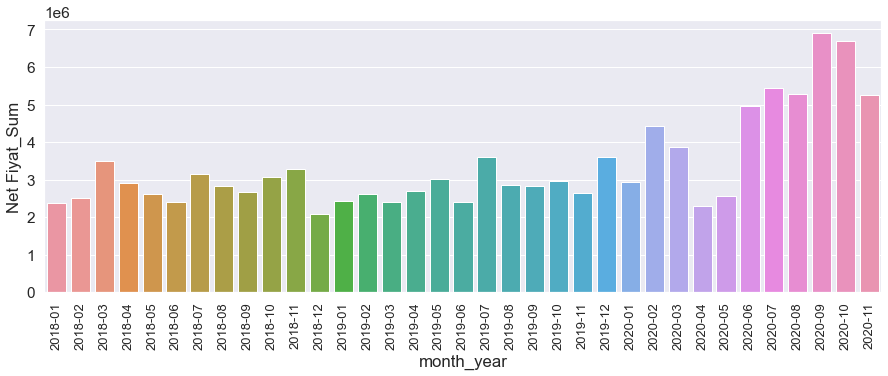

In [29]:
plt.figure(figsize=(15, 5))
sns.set(font_scale=1.4)
sns.barplot(df_temp['month_year'],df_temp['Net Fiyat_Sum'],data=df_temp)
plt.xticks(rotation='vertical', size=13)
plt.show()

In [30]:
# grouping month_year by amount
df_temp = df.groupby('month_year').sum()['Adet_Sum'].reset_index()

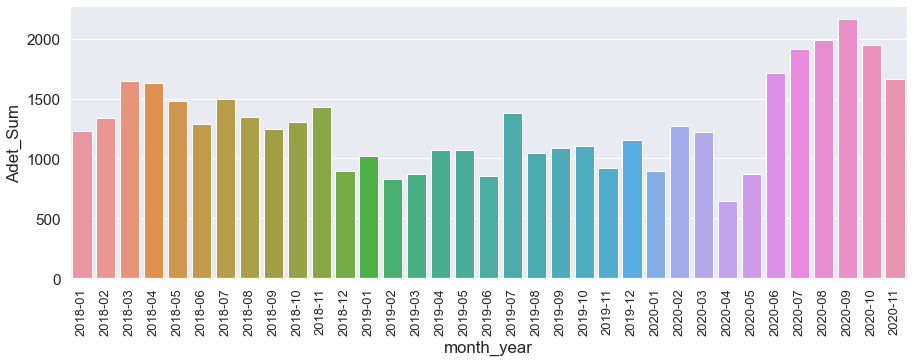

In [31]:
plt.figure(figsize=(15, 5))
sns.set(font_scale=1.4)
sns.barplot(df_temp['month_year'],df_temp['Adet_Sum'],data=df_temp)
plt.xticks(rotation='vertical', size=13)
plt.show()

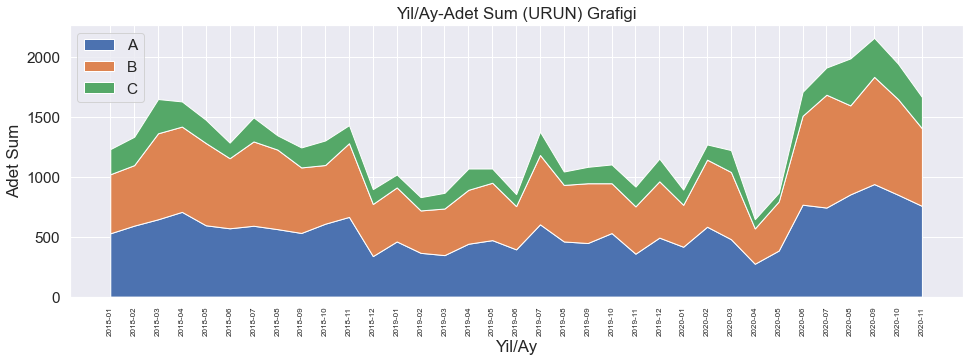

In [32]:
#Urun Adet
def stacked_area_adet(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['URUN']=="A") &(df['month_year']==i) ]['Adet_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['URUN']=="B") &(df['month_year']==i) ]['Adet_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['URUN']=="C") &(df['month_year']==i) ]['Adet_Sum'].sum())

    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['A','B','C'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Adet Sum (URUN) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Adet Sum")
    plt.show()

stacked_area_adet(df)

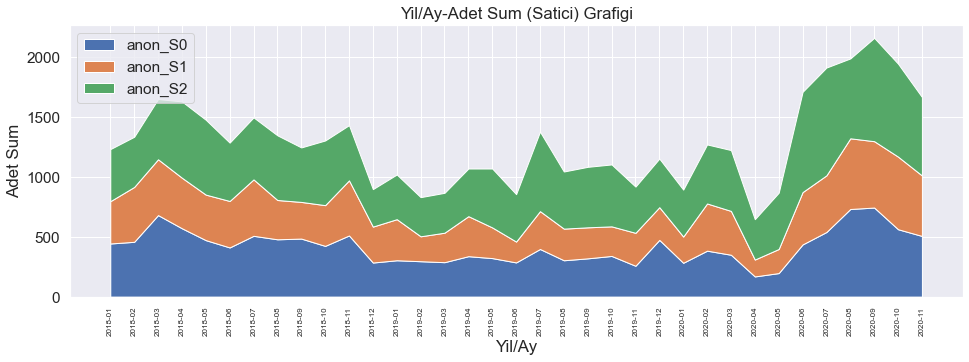

In [33]:
#Satici Adet
def stacked_area_adet_satici(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['Yetkili Satıcı Kod']=="anon_S0") &(df['month_year']==i) ]['Adet_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['Yetkili Satıcı Kod']=="anon_S1") &(df['month_year']==i) ]['Adet_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['Yetkili Satıcı Kod']=="anon_S2") &(df['month_year']==i) ]['Adet_Sum'].sum())

    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['anon_S0','anon_S1','anon_S2'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Adet Sum (Satici) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Adet Sum")
    plt.show()

stacked_area_adet_satici(df)

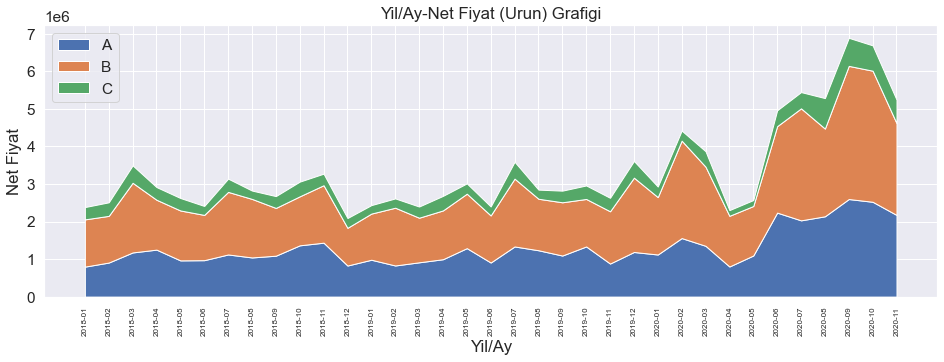

In [34]:
#Urun Fiyat
def stacked_area_fiyat(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['URUN']=="A") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['URUN']=="B") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['URUN']=="C") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())


    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['A','B','C'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Net Fiyat (Urun) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Net Fiyat")
    
    plt.show()

stacked_area_fiyat(df)

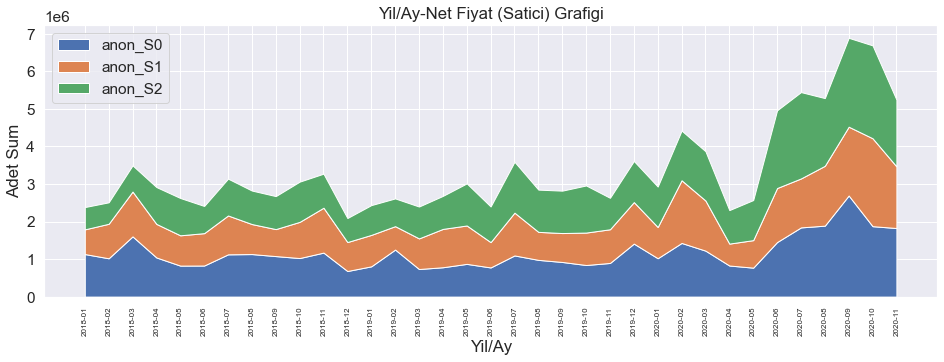

In [35]:
#Satici Fiyat
def stacked_area_adet_satici(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['Yetkili Satıcı Kod']=="anon_S0") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['Yetkili Satıcı Kod']=="anon_S1") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['Yetkili Satıcı Kod']=="anon_S2") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())

    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['anon_S0','anon_S1','anon_S2'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Net Fiyat (Satici) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Adet Sum")
    plt.show()

stacked_area_adet_satici(df)

In [36]:
#satis datasina bakalim
EyapSatış = df[df['Net Fiyat_Sum']>0]

In [37]:
EyapSatış.describe().T

,count,mean,std,min,25%,50%,75%,max
Net Fiyat_Sum,29159.0,4185.858801,7814.744026,14.400000,1547.174508,2567.100000,4652.386200,478026.000000
Adet_Sum,29159.0,1.610378,1.769548,-1.000000,1.000000,1.000000,2.000000,125.000000
New_year,29159.0,2019.038753,0.842575,2018.000000,2018.000000,2019.000000,2020.000000,2020.000000
New_month,29159.0,6.662403,3.236122,1.000000,4.000000,7.000000,9.000000,12.000000
New_day,29159.0,17.648308,8.591523,1.000000,10.000000,18.000000,25.000000,31.000000
New_dayofweek,29159.0,2.424740,1.668355,0.000000,1.000000,2.000000,4.000000,6.000000
Season,29159.0,2.692822,1.083483,1.000000,2.000000,3.000000,4.000000,4.000000
Dolar_Kur,29156.0,5.920425,1.166347,3.740450,5.301150,5.821250,6.847850,8.468900
sale_index,29159.0,112.445349,11.735816,81.557718,103.932758,112.946706,119.992083,134.042934
tufe_index,29159.0,419.228202,49.075099,330.750000,390.840000,422.840000,465.840000,498.580000


In [38]:
# Burada en çok hangi ürünün satıldığını görmek istedik.
EyapSatış.groupby('URUN')['Adet_Sum'].sum()

URUN
A    20174.0
B    20292.0
C     6491.0
Name: Adet_Sum, dtype: float64

In [39]:
# Burada en çok hangi yetkili satıcılar tarafından satıldığını görmek istedik.
EyapSatış.groupby('Yetkili Satıcı Kod')['Adet_Sum'].sum()

Yetkili Satıcı Kod
anon_S0    15224.0
anon_S1    12910.0
anon_S2    18823.0
Name: Adet_Sum, dtype: float64

In [40]:
sales=EyapSatış.groupby('URUN')['Adet_Sum'].sum().reset_index()

<AxesSubplot:xlabel='URUN', ylabel='Adet_Sum'>

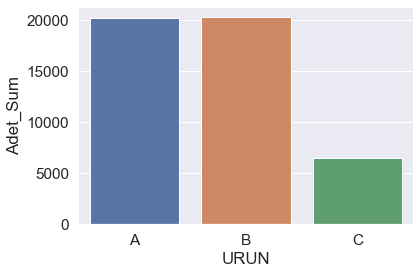

In [41]:
sns.barplot(x="URUN",y="Adet_Sum", data=sales)

Adet olarak en fazla C urunu satilmis

In [42]:
returns=df[df["Adet_Sum"]<0]

In [43]:
returns.groupby('URUN')['Adet_Sum'].sum()

URUN
A   -800.0
B   -878.0
C   -265.0
Name: Adet_Sum, dtype: float64

In [44]:
returns=returns.groupby(['URUN'])['Adet_Sum'].sum().reset_index()

<AxesSubplot:xlabel='URUN', ylabel='Adet_Sum'>

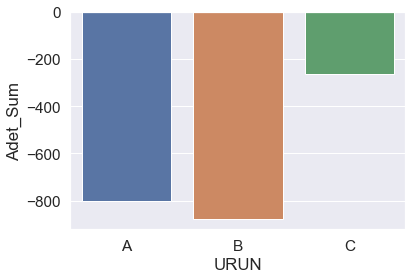

In [45]:
sns.barplot(x="URUN",y='Adet_Sum',data=returns)

In [46]:
average_price(df,['A','B','C'])
print("************************")
sale_number(df,['A','B','C'])
print("************************")
dealer_numbers(df,['anon_S0','anon_S1','anon_S2'])

A mean price: 2335.3325159464816
B mean price: 3041.5967530822
C mean price: 2034.804572865506
************************
A was sold : 20180.0 amount
B was sold : 20292.0 amount
C was sold : 6491.0 amount
************************
anon_S0 sold : 15226.0 amount
anon_S0 sold : 42290312.437776  TL
****************************************
anon_S1 sold : 12911.0 amount
anon_S1 sold : 38042217.352056  TL
****************************************
anon_S2 sold : 18826.0 amount
anon_S2 sold : 41722478.177982  TL
****************************************


In [47]:
sales2=EyapSatış.groupby("New_year").sum()[['Adet_Sum','Net Fiyat_Sum']].reset_index()
sales2

,New_year,Adet_Sum,Net Fiyat_Sum
0,2018,16849.0,3.427455e+07
1,2019,12960.0,3.520708e+07
2,2020,17148.0,5.257382e+07


Text(0.5, 1.0, 'Adet Sum by years')

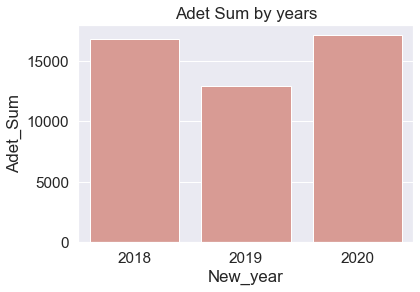

In [48]:
sns.barplot(x="New_year", y="Adet_Sum", data=sales2, color="salmon", saturation=.5)
plt.title("Adet Sum by years")

In [49]:
EyapSatış.groupby(["New_year",'URUN']).sum()['Adet_Sum']

New_year  URUN
2018      A       7152.0
          B       7386.0
          C       2311.0
2019      A       5595.0
          B       5601.0
          C       1764.0
2020      A       7427.0
          B       7305.0
          C       2416.0
Name: Adet_Sum, dtype: float64

Text(0.5, 1.0, 'Revenue by years')

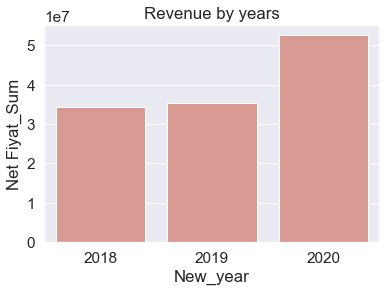

In [50]:
sns.barplot(x="New_year", y="Net Fiyat_Sum", data=sales2, color="salmon", saturation=.5)
plt.title("Revenue by years")

<AxesSubplot:xlabel='Net Fiyat_Sum', ylabel='MonthName'>

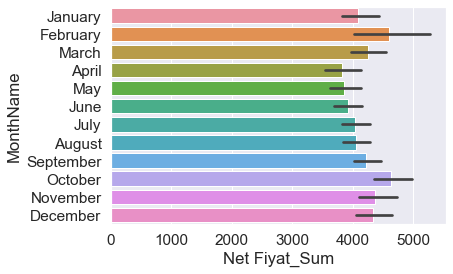

In [51]:
# Bu satışların hangi aylarda en çok yapıldığına bakalım.
sns.barplot(x="Net Fiyat_Sum", y="MonthName", data=EyapSatış)

<AxesSubplot:xlabel='Adet_Sum', ylabel='MonthName'>

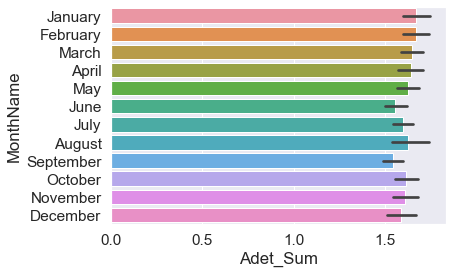

In [52]:
sns.barplot(x="Adet_Sum", y="MonthName", data=EyapSatış)
# Adet bazında baktığımızda çok büyük değişiklikler azalıyor.

<AxesSubplot:xlabel='Net Fiyat_Sum', ylabel='Weekday'>

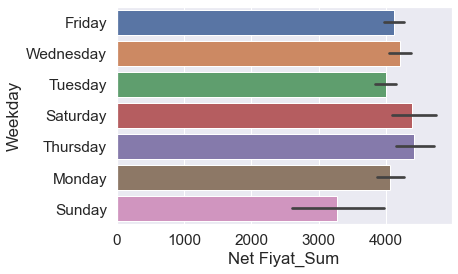

In [53]:
# Bu satışların en çok hangi günlerde yapıldığına bakalım.
sns.barplot(x="Net Fiyat_Sum", y="Weekday", data=EyapSatış)

<AxesSubplot:xlabel='Adet_Sum', ylabel='Weekday'>

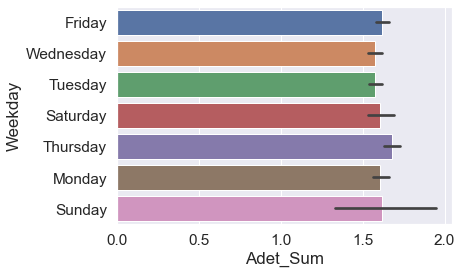

In [54]:
# Pazar, Pazartesi ve Salı günlere diğer günlere oranla görece düşük görünüyor.

# Yukarıda bu satış miktarlarının fiyat bazında en çok hangi günlerde yapıldığına bakmıştım.
# Ancak adet sayıları bize daha çok hangi gün müşterilerin geleceğiyle ilgili bilgi verebilir diye adet sayıları üzerinden görselleştiriyorum.

sns.barplot(x="Adet_Sum", y="Weekday", data=EyapSatış)

Bu şekilde adet sayılarına bakınca mağazdaki adet satışları çok farklılık göstermiyorken net fiyatların bazı günlerde daha fazla olduğunu gözlemliyoruz.

# İade edilen veriler üzerindeki analizleri ve görselleştirmeler**

In [55]:
df[df['Net Fiyat_Sum']<0].count()

Yetkili Satıcı Kod      1290
Müşteri Kod             1290
MatbuNo                 1290
FaturaTarihi            1290
Hiyerarşi 1             1290
Hiyerarşi 2             1290
Hiyerarşi 3             1290
Net Fiyat_Sum           1290
Adet_Sum                1290
URUN                    1290
month_year              1290
New_year                1290
New_month               1290
New_day                 1290
New_dayofweek           1290
New_is_month_end        1290
New_is_month_start      1290
New_is_quarter_end      1290
New_is_quarter_start    1290
New_is_year_end         1290
New_is_year_start       1290
Weekday                 1290
MonthName               1290
Season                  1290
SeasonName              1290
Dolar_Kur               1290
Gun_Tanm                1290
sale_index              1290
tufe_index              1290
ufe_index               1290
dtype: int64

1290 tane verinin net fiyat sum değeri 0'dan küçük.

In [56]:
df[df['Adet_Sum']<=0].count()

Yetkili Satıcı Kod      1297
Müşteri Kod             1297
MatbuNo                 1297
FaturaTarihi            1297
Hiyerarşi 1             1297
Hiyerarşi 2             1297
Hiyerarşi 3             1297
Net Fiyat_Sum           1297
Adet_Sum                1297
URUN                    1297
month_year              1297
New_year                1297
New_month               1297
New_day                 1297
New_dayofweek           1297
New_is_month_end        1297
New_is_month_start      1297
New_is_quarter_end      1297
New_is_quarter_start    1297
New_is_year_end         1297
New_is_year_start       1297
Weekday                 1297
MonthName               1297
Season                  1297
SeasonName              1297
Dolar_Kur               1297
Gun_Tanm                1297
sale_index              1297
tufe_index              1297
ufe_index               1297
dtype: int64

Adet sum değerlerine baktığımız zaman 1297 tane verinin sıfırdan küçük olduğunu gözlemledik.
Burada dikkatimizi net fiyat sum değeri ile adet fiyat sum değeri arasındaki fark çekti. Eksili değerler iadeyi temsil ettiği halde bir uyuşmazlık vardı. 7 veriyi droplamaya karar verdik.
Ondan önce bu 7 verinin müşteri numaralarını gözlemlemeye karar verdik.

In [57]:
# Adet sum değerinin sıfır olduğu müşteriyi gözlemledik.
df[df['Adet_Sum']==0]

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
18101,anon_S1,120.01.G2039,GNY2019000005394,2019-11-11,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,234.0,0.0,B,...,False,Monday,November,4,Autumn,5.74805,Regular Day,113.17404,437.25,450.97


In [58]:
# o müşterinin alımlarına baktık.
df[df['Müşteri Kod']=='120.01.G2039']

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
17881,anon_S1,120.01.G2039,GNY2019000005394,2019-11-11,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,768.60,1.0,B,...,False,Monday,November,4,Autumn,5.74805,Regular Day,113.17404,437.25,450.97
18098,anon_S1,120.01.G2039,GNY2019000005423,2019-11-14,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1307.16,1.0,B,...,False,Thursday,November,4,Autumn,5.76245,Regular Day,113.17404,437.25,450.97
18101,anon_S1,120.01.G2039,GNY2019000005394,2019-11-11,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,234.00,0.0,B,...,False,Monday,November,4,Autumn,5.74805,Regular Day,113.17404,437.25,450.97
24181,anon_S1,120.01.G2039,GNC2020000000045,2020-07-31,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,-65408.40,-24.0,C,...,False,Friday,July,3,Summer,6.94345,Kurban Bayramı 1. Gün,127.21436,468.56,490.33


In [59]:
(df[df['Net Fiyat_Sum']<0]['Adet_Sum']>0).count()

1290

Net fiyat sum değerinin sıfırdan küçük olduğu 1290 veriyi iade ismiyle tutup oradaki verilere incelemeye karar verdik.

In [60]:
Iade = df[df['Net Fiyat_Sum']<0]

In [61]:
Iade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 33 to 30425
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Yetkili Satıcı Kod    1290 non-null   object        
 1   Müşteri Kod           1290 non-null   object        
 2   MatbuNo               1290 non-null   object        
 3   FaturaTarihi          1290 non-null   datetime64[ns]
 4   Hiyerarşi 1           1290 non-null   object        
 5   Hiyerarşi 2           1290 non-null   object        
 6   Hiyerarşi 3           1290 non-null   object        
 7   Net Fiyat_Sum         1290 non-null   float64       
 8   Adet_Sum              1290 non-null   float64       
 9   URUN                  1290 non-null   object        
 10  month_year            1290 non-null   object        
 11  New_year              1290 non-null   int64         
 12  New_month             1290 non-null   int64         
 13  New_day         

İade veri setimizde 1290 veri var.

In [62]:
Iade.describe().T

,count,mean,std,min,25%,50%,75%,max
Net Fiyat_Sum,1290.0,-3040.911176,4079.693636,-65408.400000,-3750.000000,-1866.150000,-884.190000,-6.000000
Adet_Sum,1290.0,-1.501550,1.969216,-32.000000,-1.000000,-1.000000,-1.000000,-1.000000
New_year,1290.0,2019.115504,0.824278,2018.000000,2018.000000,2019.000000,2020.000000,2020.000000
New_month,1290.0,7.334884,3.213303,1.000000,5.000000,8.000000,10.000000,12.000000
New_day,1290.0,17.424806,9.070160,1.000000,10.000000,17.000000,25.000000,31.000000
New_dayofweek,1290.0,2.185271,1.662510,0.000000,1.000000,2.000000,4.000000,6.000000
Season,1290.0,2.826357,1.104720,1.000000,2.000000,3.000000,4.000000,4.000000
Dolar_Kur,1290.0,6.093790,1.190908,3.745500,5.351313,5.863075,7.102400,8.468900
sale_index,1290.0,113.911181,12.029085,81.557718,105.934330,115.990100,126.347845,134.042934
tufe_index,1290.0,426.817930,48.349285,330.750000,395.480000,435.590000,472.610000,498.580000


In [63]:
return_temp=Iade.groupby(["URUN",'New_year']).sum()[['Adet_Sum',"Net Fiyat_Sum"]].reset_index()

In [64]:
return_temp.groupby(["URUN"]).sum()[['Adet_Sum',"Net Fiyat_Sum"]].reset_index()

,URUN,Adet_Sum,Net Fiyat_Sum
0,A,-794.0,-1.488267e+06
1,B,-878.0,-1.967871e+06
2,C,-265.0,-4.666372e+05


<AxesSubplot:xlabel='URUN', ylabel='Adet_Sum'>

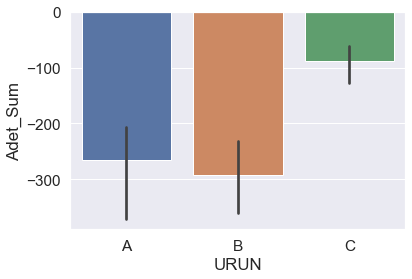

In [65]:
# İade edilen verilerden en çok iade edilen ürünü bulalım.
# En çok B ürünü en az C ürünü iade edilmiş.
sns.barplot(x="URUN",y="Adet_Sum", data=return_temp)

In [66]:
labels = 'Iade_A', 'Iade_B', 'Iade_C'
sections = [543,638,108]
colors = ['c', 'g', 'y']

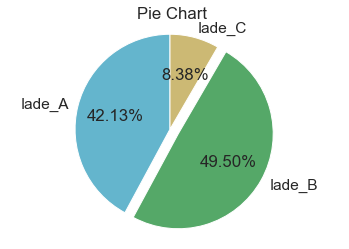

In [67]:
plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        explode = (0, 0.1, 0),
        autopct = '%1.2f%%')

plt.axis('equal') 
plt.title('Pie Chart ')
plt.show()

<AxesSubplot:xlabel='New_year', ylabel='Net Fiyat_Sum'>

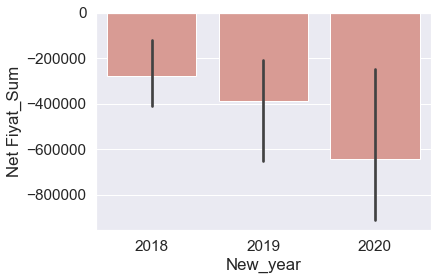

In [68]:
# Iade edilen ürünlerin toplam fiyatlarının yıllara göre incelenmesi.
sns.barplot(x="New_year", y="Net Fiyat_Sum", data=return_temp, color="salmon", saturation=.5)

<AxesSubplot:xlabel='New_year', ylabel='Adet_Sum'>

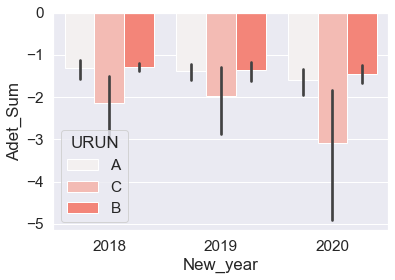

In [69]:
sns.barplot(x="New_year", y="Adet_Sum",hue='URUN', data=Iade,
                 color="salmon", saturation=.9)

<AxesSubplot:xlabel='New_year', ylabel='Adet_Sum'>

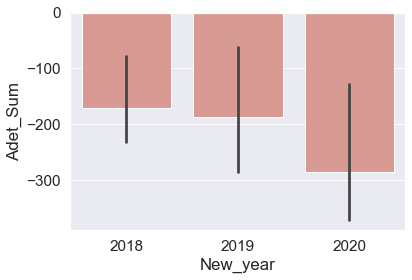

In [70]:
# En fazla iade miktarı 2020 yılında gerçekleşmiş.
# Buradan adet değerlerine bakarak 2020'ye doğru iade edilen adet artmış mı diye inceleyelim.
sns.barplot(x="New_year", y="Adet_Sum", data=return_temp, color="salmon", saturation=.5)

2018 ve 2019 yılında adet değerleri yakınlık gösterirken net fiyat değerleri değişiklik göstermiş. 2020 yılında ise iade edilen adet sayısı artmış buna bağlı olarak da net fiyat tutarı da artmış.

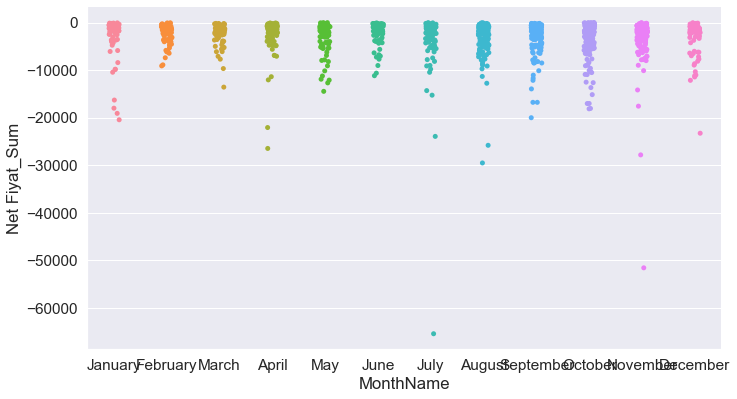

In [71]:
# Aylara göre yapılan iadelerin net fiyat tutarını inceleyelim
import seaborn as sns 
g = sns.catplot(data=Iade, x='MonthName', y='Net Fiyat_Sum')
g.fig.set_figwidth(13.27)
g.fig.set_figheight(5.7)

In [72]:
# buradan iadeler üzerine net fiyat toplamının şubat ayında diğer aylara görece daha az olduğunu gördük.

<AxesSubplot:xlabel='MonthName', ylabel='Net Fiyat_Sum'>

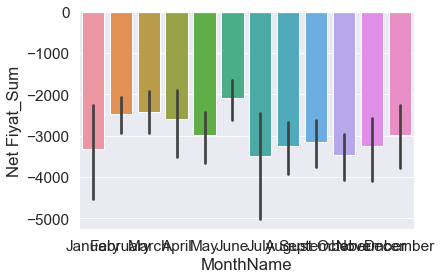

In [73]:
sns.barplot(x="MonthName", y="Net Fiyat_Sum", data=Iade)

Yukarıda aylara göre iade miktarlarını görselleştirince yıllara göre nasıl olduğunu merak ettim.  Hep temmuz ayında iade miktarı fazla diye görebilmek için.

<AxesSubplot:xlabel='MonthName', ylabel='Net Fiyat_Sum'>

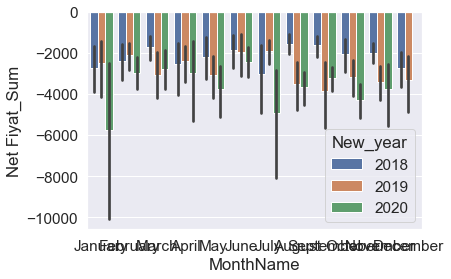

In [74]:
sns.barplot(x="MonthName", y="Net Fiyat_Sum", hue='New_year', data=Iade)

In [75]:
iade_group=Iade.groupby(["Yetkili Satıcı Kod",'URUN',"New_year"]).sum()['Adet_Sum'].reset_index()

<AxesSubplot:xlabel='Yetkili Satıcı Kod', ylabel='Adet_Sum'>

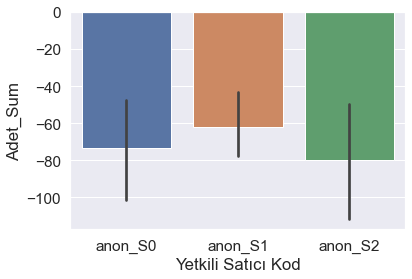

In [76]:
# Şimdi yetkili satıcılara bakalım.
sns.barplot(x="Yetkili Satıcı Kod",y='Adet_Sum' ,data=iade_group)

<AxesSubplot:xlabel='New_year', ylabel='Adet_Sum'>

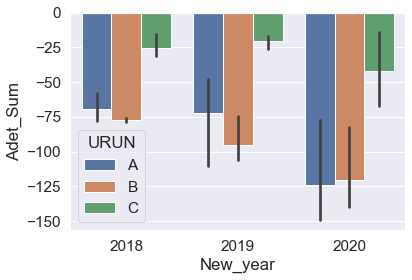

In [77]:
sns.barplot(x="New_year",y='Adet_Sum', hue="URUN", data=iade_group)
# Bu grafikten yıllara göre iade edilen B ürünü miktarının arttığını gözlemliyoruz.

In [78]:
#Yil ve aylara gore satis grafikleri
df_temp = df.groupby(['New_month',"New_year"]).sum()[['Net Fiyat_Sum',"Adet_Sum"]].reset_index()

<AxesSubplot:xlabel='New_month', ylabel='Adet_Sum'>

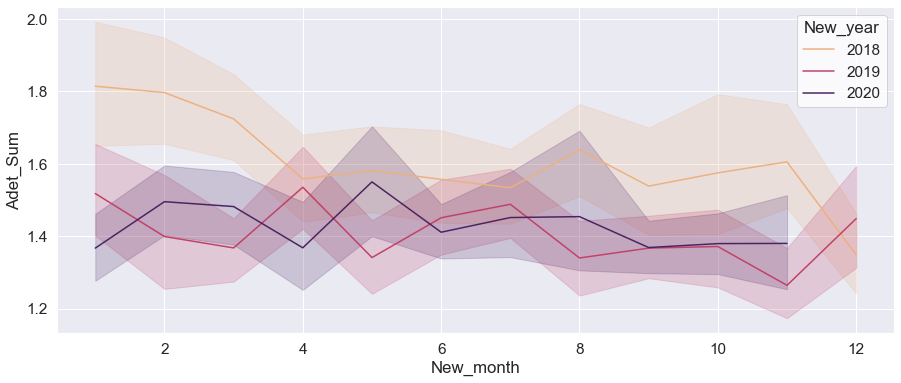

In [79]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df,  
             x='New_month',  
             y='Adet_Sum',  
             hue='New_year', 
             legend='full',palette="flare") 



<AxesSubplot:xlabel='New_month', ylabel='Net Fiyat_Sum'>

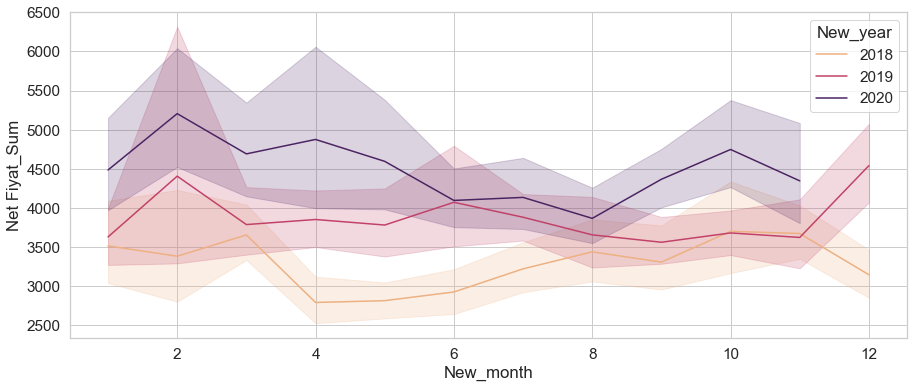

In [80]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df,  
             x='New_month',  
             y='Net Fiyat_Sum',  
             hue='New_year', 
             legend='full',palette="flare") 

<AxesSubplot:xlabel='Season', ylabel='Adet_Sum'>

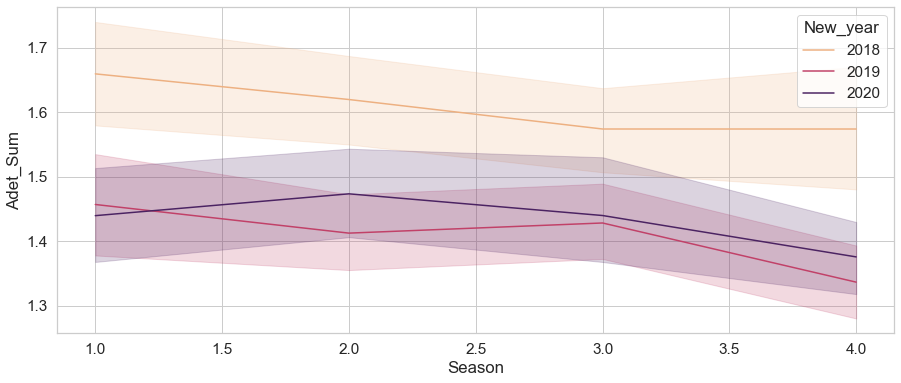

In [81]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df,  
             x='Season',  
             y='Adet_Sum',  
             hue='New_year', 
             legend='full',palette="flare") 


<AxesSubplot:xlabel='Season', ylabel='Net Fiyat_Sum'>

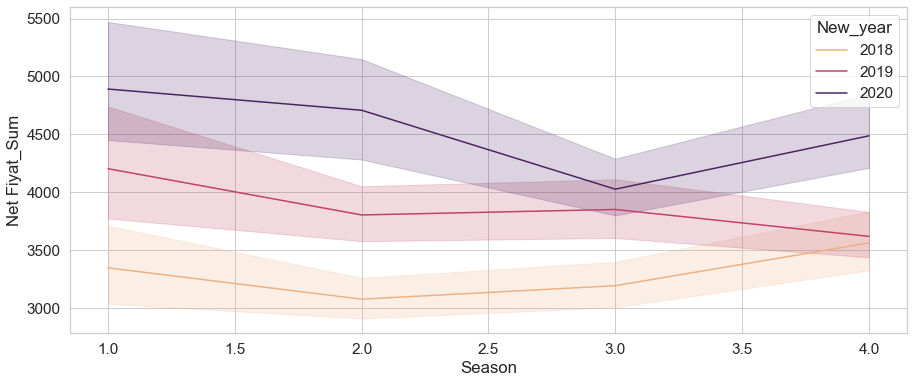

In [82]:
fig, ax = plt.subplots(figsize=(15, 6)) 
sns.set_style("whitegrid")
sns.lineplot(data=df,  
             x='Season',  
             y='Net Fiyat_Sum',  
             hue='New_year', 
             legend='full',palette="flare") 

In [83]:
# grouping month_year by revenue
df_temp = df.groupby('month_year').sum()['Net Fiyat_Sum'].reset_index()

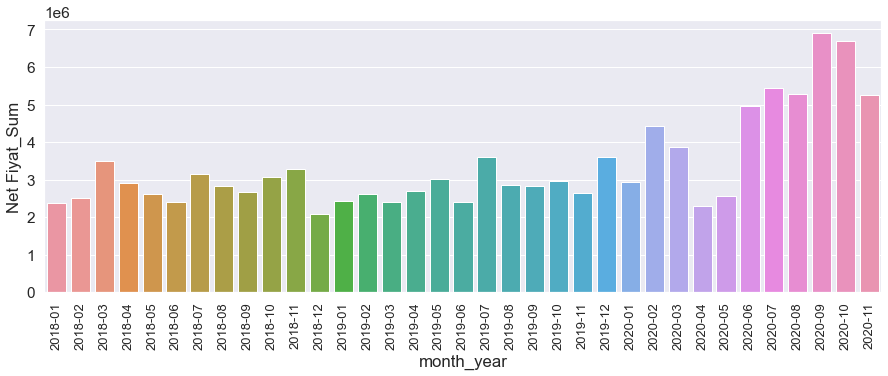

In [84]:
plt.figure(figsize=(15, 5))
sns.set(font_scale=1.4)
sns.barplot(df_temp['month_year'],df_temp['Net Fiyat_Sum'],data=df_temp)
plt.xticks(rotation='vertical', size=13)
plt.show()

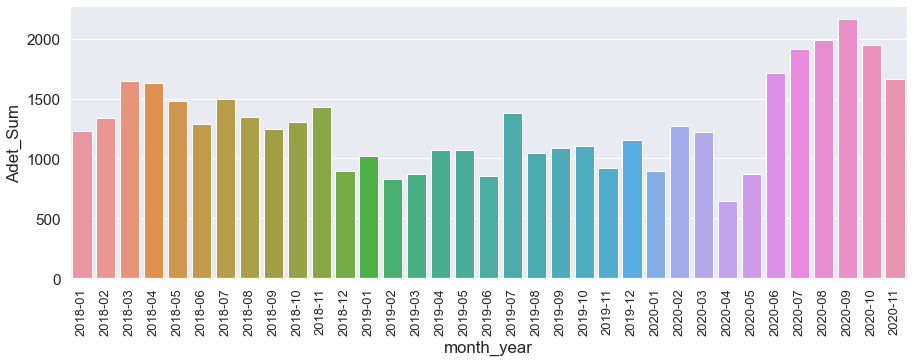

In [85]:
# grouping month_year by amount
df_temp = df.groupby('month_year').sum()['Adet_Sum'].reset_index()

plt.figure(figsize=(15, 5))
sns.set(font_scale=1.4)
sns.barplot(df_temp['month_year'],df_temp['Adet_Sum'],data=df_temp)
plt.xticks(rotation='vertical', size=13)
plt.show()

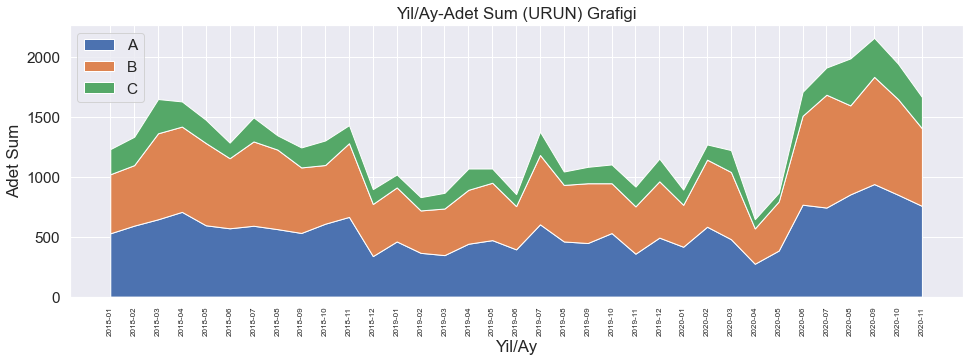

In [86]:
#Urun Adet
def stacked_area_adet(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['URUN']=="A") &(df['month_year']==i) ]['Adet_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['URUN']=="B") &(df['month_year']==i) ]['Adet_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['URUN']=="C") &(df['month_year']==i) ]['Adet_Sum'].sum())

    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['A','B','C'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Adet Sum (URUN) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Adet Sum")
    plt.show()

stacked_area_adet(df)

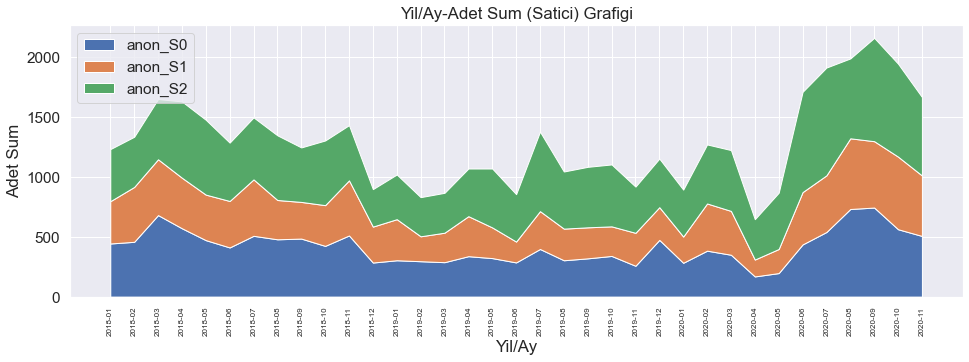

In [87]:
#Satici Adet
def stacked_area_adet_satici(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['Yetkili Satıcı Kod']=="anon_S0") &(df['month_year']==i) ]['Adet_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['Yetkili Satıcı Kod']=="anon_S1") &(df['month_year']==i) ]['Adet_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['Yetkili Satıcı Kod']=="anon_S2") &(df['month_year']==i) ]['Adet_Sum'].sum())

    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['anon_S0','anon_S1','anon_S2'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Adet Sum (Satici) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Adet Sum")
    plt.show()

stacked_area_adet_satici(df)

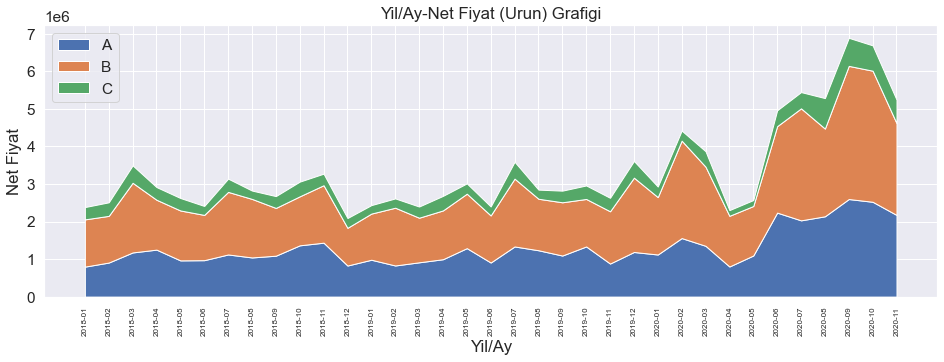

In [88]:
#Urun Fiyat
def stacked_area_fiyat(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['URUN']=="A") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['URUN']=="B") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['URUN']=="C") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())


    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['A','B','C'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Net Fiyat (Urun) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Net Fiyat")
    
    plt.show()

stacked_area_fiyat(df)

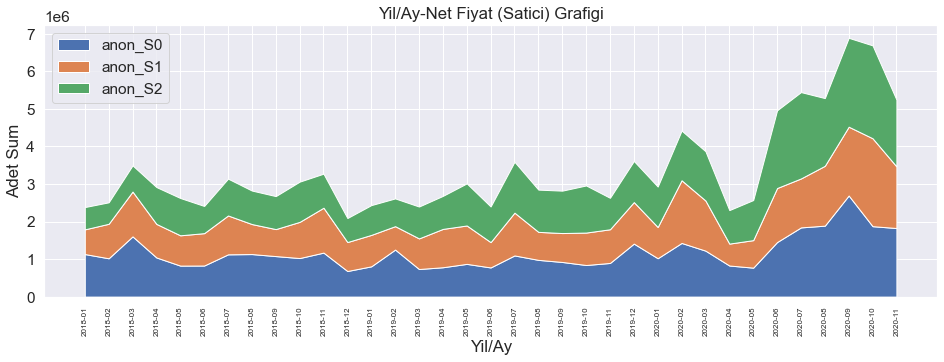

In [89]:
#Satici Fiyat
def stacked_area_adet_satici(df):
    x=list(df['month_year'].unique())
    y1=[]
    y2=[]
    y3=[]

    for i in df['month_year'].unique():
        y1.append(df[(df['Yetkili Satıcı Kod']=="anon_S0") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())

    for i in df['month_year'].unique():
        y2.append(df[(df['Yetkili Satıcı Kod']=="anon_S1") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())


    for i in df['month_year'].unique():
        y3.append(df[(df['Yetkili Satıcı Kod']=="anon_S2") &(df['month_year']==i) ]['Net Fiyat_Sum'].sum())

    # Basic stacked area chart.
    plt.figure(figsize=(16, 5))
    plt.xticks(rotation='vertical', size=8)

    plt.stackplot(x,y1, y2, y3, labels=['anon_S0','anon_S1','anon_S2'])
    plt.legend(loc='upper left')
    plt.title("Yil/Ay-Net Fiyat (Satici) Grafigi")
    plt.xlabel("Yil/Ay")
    plt.ylabel("Adet Sum")
    plt.show()

stacked_area_adet_satici(df)

## Dolar Grafikleri

In [90]:
dolar_temp=df.groupby("Dolar_Kur").sum()['Adet_Sum'].reset_index()
dolar_temp

,Dolar_Kur,Adet_Sum
0,3.74045,51.0
1,3.74550,22.0
2,3.74875,115.0
3,3.74895,106.0
4,3.75570,155.0
...,...,...
702,8.38355,34.0
703,8.44930,24.0
704,8.46220,97.0
705,8.46290,75.0


<AxesSubplot:xlabel='Dolar_Kur', ylabel='Adet_Sum'>

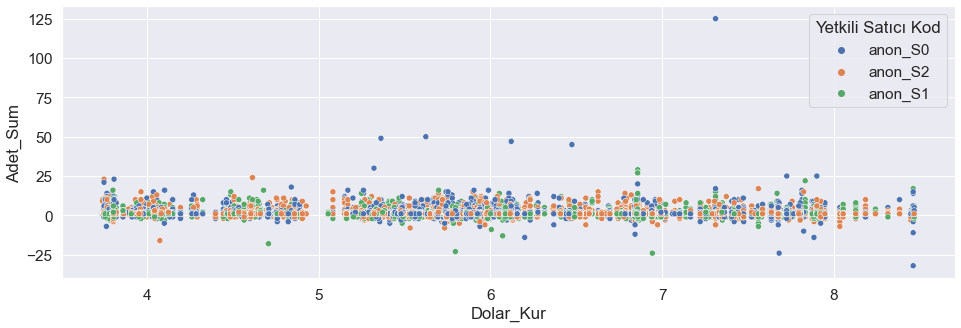

In [91]:
plt.figure(figsize=(16, 5))
sns.scatterplot(x='Dolar_Kur',y='Adet_Sum',data=df, hue='Yetkili Satıcı Kod')

<AxesSubplot:xlabel='Dolar_Kur', ylabel='Net Fiyat_Sum'>

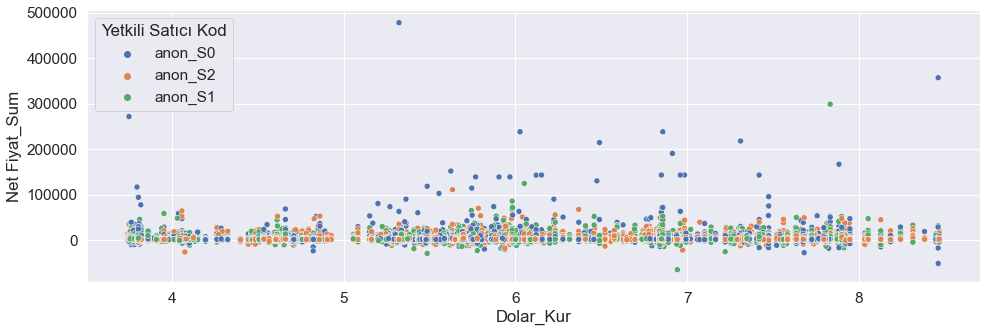

In [92]:
plt.figure(figsize=(16, 5))
sns.scatterplot(x='Dolar_Kur',y='Net Fiyat_Sum',data=df, hue='Yetkili Satıcı Kod')

In [93]:
df_temp=df.groupby(['SeasonName']).sum()['Adet_Sum'].reset_index()
df_temp2=df.groupby(['SeasonName','URUN']).sum()['Adet_Sum'].reset_index()
df_temp

,SeasonName,Adet_Sum
0,Autumn,12862.0
1,Spring,10503.0
2,Summer,13021.0
3,Winter,8634.0


Text(0.5, 1.0, 'Season Sales')

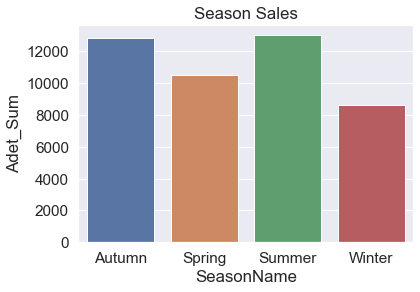

In [94]:
sns.barplot(x='SeasonName',y='Adet_Sum',data=df_temp)
plt.title("Season Sales")

Text(0.5, 1.0, 'Season/Product')

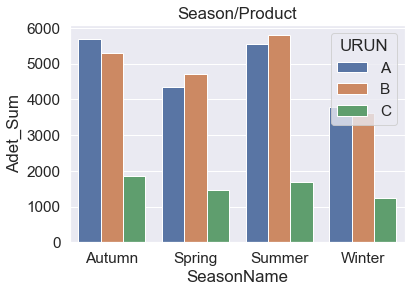

In [95]:
sns.barplot(x='SeasonName',y='Adet_Sum',data=df_temp2,hue="URUN")
plt.title("Season/Product")

In [196]:
df.groupby('Gun_Tanm')['Adet_Sum'].sum()

Gun_Tanm
1 Mayıs Emek ve Dayanışma Günü                         12.0
15 Temmuz Demokrasi Bayramı                           160.0
19 Mayıs Atatürk’ü Anma, Gençlik ve Spor Bayramı       33.0
23 Nisan Ulusal Egemenlik ve Çocuk Bayramı            123.0
29 Ekim Cumhuriyet Bayramı                             43.0
30 Ağustos Zafer Bayramı                               67.0
31 Aralık Yılbaşı gecesi                              212.0
Kurban Bayramı 1. Gün                                  -9.0
Kurban Bayramı 2. Gün                                  69.0
Kurban Bayramı 4. Gün                                  74.0
Kurban Bayramı Arefe                                   48.0
Ramazan Bayrami Arefe                                  39.0
Ramazan Bayramı resmi tatil edildi(Cuma)                7.0
Ramazan Bayramı resmi tatil edildi(Pazartesi)          12.0
Regular Day                                         44130.0
Name: Adet_Sum, dtype: float64

In [198]:
df[df['Gun_Tanm']=="15 Temmuz Demokrasi Bayramı"]['FaturaTarihi'].value_counts()

2020-07-15    67
2019-07-15    54
Name: FaturaTarihi, dtype: int64

In [96]:
## Ozel-Gun Grafikleri

In [97]:
df.groupby('Gun_Tanm')['Adet_Sum'].mean()

Gun_Tanm
1 Mayıs Emek ve Dayanışma Günü                      0.923077
15 Temmuz Demokrasi Bayramı                         1.322314
19 Mayıs Atatürk’ü Anma, Gençlik ve Spor Bayramı    1.137931
23 Nisan Ulusal Egemenlik ve Çocuk Bayramı          2.016393
29 Ekim Cumhuriyet Bayramı                          1.162162
30 Ağustos Zafer Bayramı                            1.116667
31 Aralık Yılbaşı gecesi                            1.171271
Kurban Bayramı 1. Gün                              -0.692308
Kurban Bayramı 2. Gün                               1.468085
Kurban Bayramı 4. Gün                               1.541667
Kurban Bayramı Arefe                                0.979592
Ramazan Bayrami Arefe                               1.695652
Ramazan Bayramı resmi tatil edildi(Cuma)            1.750000
Ramazan Bayramı resmi tatil edildi(Pazartesi)       1.000000
Regular Day                                         1.483311
Name: Adet_Sum, dtype: float64

In [98]:
df_temp = df.groupby('Gun_Tanm').mean()['Net Fiyat_Sum'].reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Regular Day'),
  Text(1, 0, '23 Nisan Ulusal Egemenlik ve Çocuk Bayramı'),
  Text(2, 0, '1 Mayıs Emek ve Dayanışma Günü'),
  Text(3, 0, '19 Mayıs Atatürk’ü Anma, Gençlik ve Spor Bayramı'),
  Text(4, 0, 'Ramazan Bayrami Arefe'),
  Text(5, 0, '30 Ağustos Zafer Bayramı'),
  Text(6, 0, 'Kurban Bayramı Arefe'),
  Text(7, 0, '29 Ekim Cumhuriyet Bayramı'),
  Text(8, 0, '31 Aralık Yılbaşı gecesi'),
  Text(9, 0, 'Ramazan Bayramı resmi tatil edildi(Pazartesi)'),
  Text(10, 0, 'Ramazan Bayramı resmi tatil edildi(Cuma)'),
  Text(11, 0, '15 Temmuz Demokrasi Bayramı'),
  Text(12, 0, 'Kurban Bayramı 2. Gün'),
  Text(13, 0, 'Kurban Bayramı 4. Gün'),
  Text(14, 0, 'Kurban Bayramı 1. Gün')])

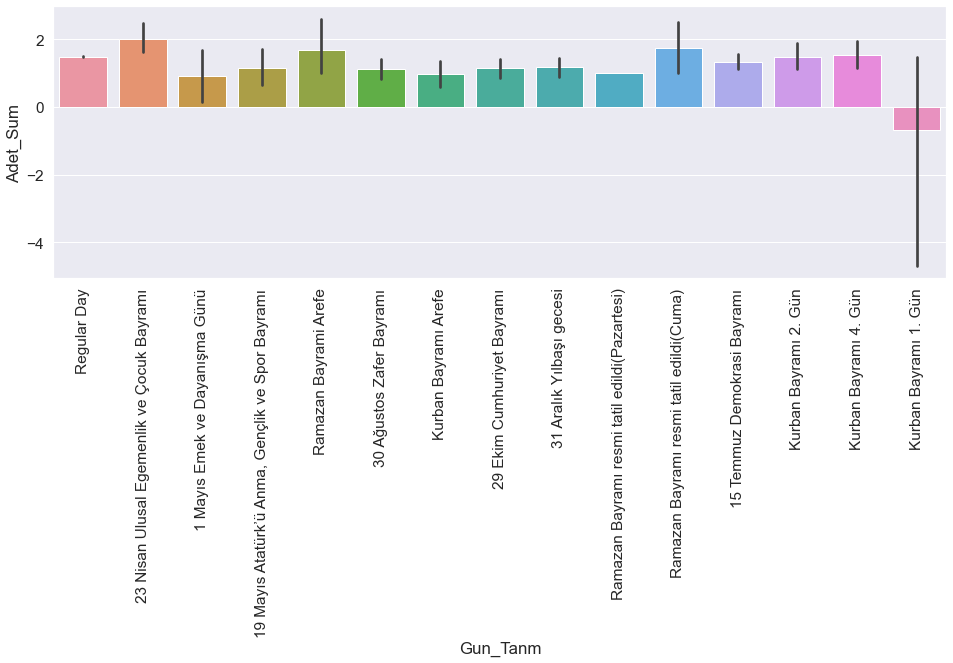

In [99]:
plt.figure(figsize=(16, 5))
sns.barplot(df['Gun_Tanm'],df['Adet_Sum'],data=df_temp)
plt.xticks(rotation='vertical')

In [189]:
products_byday=df.groupby(["Gun_Tanm",'FaturaTarihi'])[['Adet_Sum',"Net Fiyat_Sum"]].sum().reset_index()


In [192]:
products_byday=products_byday.groupby('Gun_Tanm')['Adet_Sum','Net Fiyat_Sum'].mean()

In [166]:
products_byday.unstack()

Gun_Tanm       0                       1 Mayıs Emek ve Dayanışma Günü
               1                          15 Temmuz Demokrasi Bayramı
               2     19 Mayıs Atatürk’ü Anma, Gençlik ve Spor Bayramı
               3           23 Nisan Ulusal Egemenlik ve Çocuk Bayramı
               4                           29 Ekim Cumhuriyet Bayramı
               5                             30 Ağustos Zafer Bayramı
               6                             31 Aralık Yılbaşı gecesi
               7                                Kurban Bayramı 1. Gün
               8                                Kurban Bayramı 2. Gün
               9                                Kurban Bayramı 4. Gün
               10                                Kurban Bayramı Arefe
               11                               Ramazan Bayrami Arefe
               12            Ramazan Bayramı resmi tatil edildi(Cuma)
               13       Ramazan Bayramı resmi tatil edildi(Pazartesi)
               14   

<AxesSubplot:title={'center':'Special Day Heatmap'}, ylabel='Gun_Tanm'>

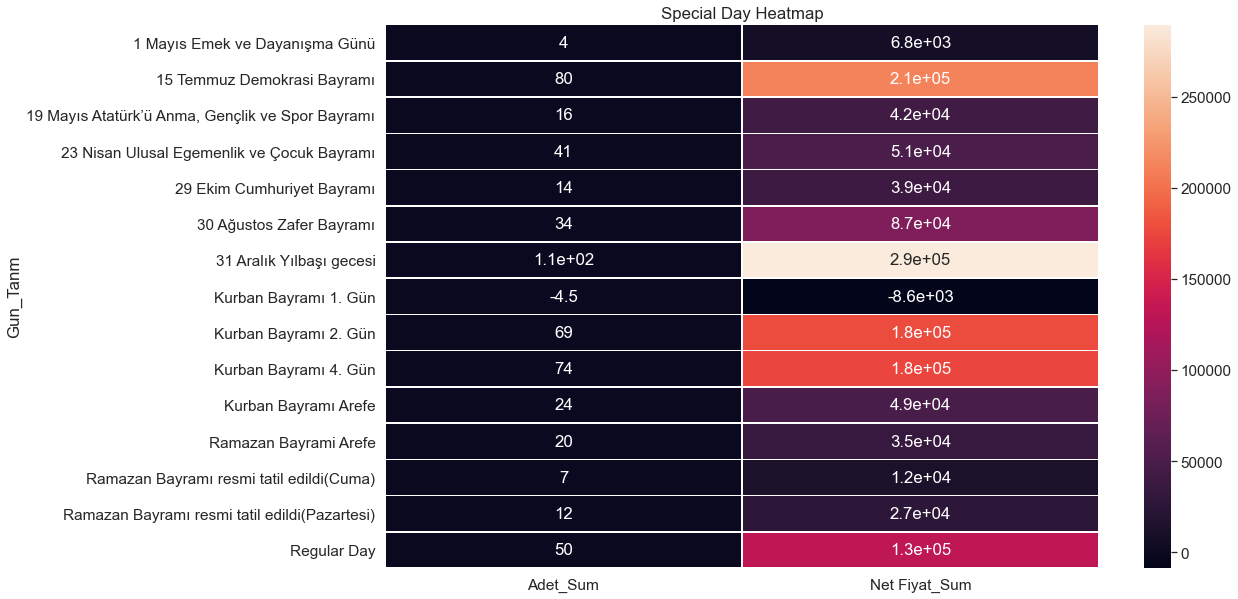

In [195]:
products_byday.unstack()

plt.figure(figsize=(16, 10))
sns.set(font_scale=1.4)
plt.title("Special Day Heatmap")
sns.heatmap(products_byday,annot=True,linewidths=.5)

# Rule based fraud detect

Ramazan bayraminin birinci gununde negatif deger aldigimiz icin burda iade sayisi aldigindan fazla olan musterileri bulduk ve ozellikle aradaki fark 10 olan musterileri listeledik

In [505]:
min_return=df[df['Gun_Tanm']=='Kurban Bayramı 1. Gün']['Adet_Sum'].min()
min_return_customer=df[df['Adet_Sum']==min_return]['Müşteri Kod'].min()
df[df['Müşteri Kod']==min_return_customer]

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
17881,anon_S1,120.01.G2039,GNY2019000005394,2019-11-11,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,768.60,1.0,B,...,False,Monday,November,4,Autumn,5.74805,Regular Day,113.17404,437.25,450.97
18098,anon_S1,120.01.G2039,GNY2019000005423,2019-11-14,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,1307.16,1.0,B,...,False,Thursday,November,4,Autumn,5.76245,Regular Day,113.17404,437.25,450.97
18101,anon_S1,120.01.G2039,GNY2019000005394,2019-11-11,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,234.00,0.0,B,...,False,Monday,November,4,Autumn,5.74805,Regular Day,113.17404,437.25,450.97
24181,anon_S1,120.01.G2039,GNC2020000000045,2020-07-31,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,-65408.40,-24.0,C,...,False,Friday,July,3,Summer,6.94345,Kurban Bayramı 1. Gün,127.21436,468.56,490.33


In [506]:
tf=df.groupby('Müşteri Kod')['Adet_Sum'].sum()<0

In [507]:
tf.value_counts()

print("Customer amount that has more returns:",tf.value_counts()[1])

Customer amount that has more returns: 27


In [508]:
tff=list(tf[tf].index)

for i in tff:
    if df[df["Müşteri Kod"]==i]['Adet_Sum'].sum() <-10:
        print(i,":",df[df["Müşteri Kod"]==i]['Adet_Sum'].sum())

120.01.E3956 : -23.0
120.01.G2039 : -22.0
120.01.Y1561 : -26.0
120.07.536 : -21.0
120.14.359 : -12.0
120.22.557 : -27.0
120.SB.ISP0085 : -11.0


In [509]:
df[df["Müşteri Kod"]=='120.01.E3956']

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
18626,anon_S1,120.01.E3956,056365,2019-12-10,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-11429.76,-23.0,B,...,False,Tuesday,December,1,Winter,5.79575,Regular Day,134.042934,440.5,454.08


In [510]:
df[df["Müşteri Kod"]=='120.01.Y1561']

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
13127,anon_S1,120.01.Y1561,151198,2019-05-25,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,-8197.5,-13.0,C,...,False,Saturday,May,2,Spring,6.0711,Regular Day,109.12343,413.52,456.74
13261,anon_S1,120.01.Y1561,151198,2019-05-25,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-7956.6,-13.0,B,...,False,Saturday,May,2,Spring,6.0711,Regular Day,109.12343,413.52,456.74


In [511]:
df[df["Müşteri Kod"]=='120.07.536']

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
10745,anon_S0,120.07.536,OLC2019000000556,2019-01-31,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,3060.24,2.0,B,...,False,Thursday,January,1,Winter,5.28285,Regular Day,89.628032,398.07,424.86
11354,anon_S0,120.07.536,GRP2019000000007,2019-02-25,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-2592.24,-2.0,B,...,False,Monday,February,1,Winter,5.32160,Regular Day,89.309466,398.71,425.26
11588,anon_S0,120.07.536,OLC2019000001705,2019-03-29,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,7550.10,3.0,A,...,False,Friday,March,2,Spring,5.54730,Regular Day,105.158657,402.81,431.98
29843,anon_S0,120.07.536,GRP2020000000123,2020-11-17,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,-27811.44,-24.0,C,...,False,Tuesday,November,4,Autumn,7.68200,Regular Day,127.058653,498.58,555.18


In [512]:
df[df["Müşteri Kod"]=='120.14.359']

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
13132,anon_S0,120.14.359,OLC2019000002543,2019-05-11,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,5193.36,4.0,C,...,False,Saturday,May,2,Spring,6.1184,Regular Day,109.123430,413.52,456.74
13159,anon_S0,120.14.359,OLC2019000002543,2019-05-11,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,8020.80,5.0,C,...,False,Saturday,May,2,Spring,6.1184,Regular Day,109.123430,413.52,456.74
17042,anon_S0,120.14.359,OLC2019000005715,2019-10-24,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,1473.84,1.0,C,...,False,Thursday,October,4,Autumn,5.7764,Regular Day,112.629763,435.59,451.31
17079,anon_S0,120.14.359,OLC2019000005715,2019-10-24,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,10515.60,6.0,C,...,False,Thursday,October,4,Autumn,5.7764,Regular Day,112.629763,435.59,451.31
28672,anon_S0,120.14.359,NIL2020000000052,2020-10-20,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-8384.40,-14.0,B,...,False,Tuesday,October,4,Autumn,7.8849,Regular Day,126.999338,487.38,533.44
28994,anon_S0,120.14.359,NIL2020000000052,2020-10-20,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-17007.84,-14.0,B,...,False,Tuesday,October,4,Autumn,7.8849,Regular Day,126.999338,487.38,533.44


In [513]:
df[df["Müşteri Kod"]=='120.22.557']

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
26547,anon_S0,120.22.557,EO12020000007982,2020-09-30,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,36391.440,16.0,A,...,False,Wednesday,September,4,Autumn,7.81505,Regular Day,126.347845,477.21,515.13
28215,anon_S0,120.22.557,EO12020000008855,2020-10-27,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,14976.000,5.0,A,...,False,Tuesday,October,4,Autumn,8.03570,Regular Day,126.999338,487.38,533.44
29593,anon_S0,120.22.557,EO12020000009137,2020-11-04,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,3182.400,1.0,A,...,False,Wednesday,November,4,Autumn,8.46220,Regular Day,127.058653,498.58,555.18
29720,anon_S0,120.22.557,008451,2020-11-05,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,-51552.240,-32.0,A,...,False,Thursday,November,4,Autumn,8.46290,Regular Day,127.058653,498.58,555.18
29721,anon_S0,120.22.557,008452,2020-11-05,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,-6239.280,-4.0,A,...,False,Thursday,November,4,Autumn,8.46290,Regular Day,127.058653,498.58,555.18
29722,anon_S0,120.22.557,008453,2020-11-05,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,-17567.520,-11.0,A,...,False,Thursday,November,4,Autumn,8.46290,Regular Day,127.058653,498.58,555.18
30046,anon_S0,120.22.557,000746.,2020-11-20,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-1408.680,-1.0,B,...,False,Friday,November,4,Autumn,7.67680,Regular Day,127.058653,498.58,555.18
30417,anon_S0,120.22.557,000746.,2020-11-20,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-4445.532,-6.0,B,...,False,Friday,November,4,Autumn,7.67680,Regular Day,127.058653,498.58,555.18
30418,anon_S0,120.22.557,EO12020000009247,2020-11-07,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,4133.610,5.0,B,...,False,Saturday,November,4,Autumn,8.46890,Regular Day,127.058653,498.58,555.18


In [514]:
df[df["Müşteri Kod"]=='120.SB.ISP0085']

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,FaturaTarihi,Hiyerarşi 1,Hiyerarşi 2,Hiyerarşi 3,Net Fiyat_Sum,Adet_Sum,URUN,...,New_is_year_start,Weekday,MonthName,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
1010,anon_S2,120.SB.ISP0085,AR42018000000312,2018-02-16,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,1539.9,1.0,A,...,False,Friday,February,1,Winter,3.7755,Regular Day,95.053966,333.17,328.17
1671,anon_S2,120.SB.ISP0085,091322,2018-03-07,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,-1926.0,-1.0,A,...,False,Wednesday,March,2,Spring,3.8035,Regular Day,109.662532,336.48,333.21
1804,anon_S2,120.SB.ISP0085,091321,2018-03-07,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,-1071.9,-1.0,A,...,False,Wednesday,March,2,Spring,3.8035,Regular Day,109.662532,336.48,333.21
1805,anon_S2,120.SB.ISP0085,091322,2018-03-07,"Armatür, Aksesuar & Gömme Reze",Armatürler,Armatür,-4989.6,-4.0,A,...,False,Wednesday,March,2,Spring,3.8035,Regular Day,109.662532,336.48,333.21
1874,anon_S2,120.SB.ISP0085,091322,2018-03-07,"Armatür, Aksesuar & Gömme Reze",Gömme/Plastik Rezervuar,Gömme Rezervuar,-2466.0,-3.0,C,...,False,Wednesday,March,2,Spring,3.8035,Regular Day,109.662532,336.48,333.21
2027,anon_S2,120.SB.ISP0085,091322,2018-03-07,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-3867.0,-1.0,B,...,False,Wednesday,March,2,Spring,3.8035,Regular Day,109.662532,336.48,333.21
2167,anon_S2,120.SB.ISP0085,091322,2018-03-07,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,Büyük Parçalar,-5226.0,-2.0,B,...,False,Wednesday,March,2,Spring,3.8035,Regular Day,109.662532,336.48,333.21


# Model

In [288]:
df.columns

Index(['Yetkili Satıcı Kod', 'Müşteri Kod', 'MatbuNo', 'FaturaTarihi',
       'Hiyerarşi 1', 'Hiyerarşi 2', 'Hiyerarşi 3', 'Net Fiyat_Sum',
       'Adet_Sum', 'URUN', 'month_year', 'New_year', 'New_month', 'New_day',
       'New_dayofweek', 'New_is_month_end', 'New_is_month_start',
       'New_is_quarter_end', 'New_is_quarter_start', 'New_is_year_end',
       'New_is_year_start', 'Weekday', 'MonthName', 'Season', 'SeasonName',
       'Dolar_Kur', 'Gun_Tanm', 'sale_index', 'tufe_index', 'ufe_index'],
      dtype='object')

In [289]:
df.drop(["month_year", 'FaturaTarihi', 'Weekday', "MonthName", "Hiyerarşi 3"], axis=1, inplace=True)

In [290]:
len(df.columns)

25

In [291]:
def grab_col(df):
    cat_col1 = [col for col in df.columns if df[col].dtype == "O"]
    cat_but_car = [col for col in cat_col1 if df[col].nunique() > 10]
    cat_col = [col for col in cat_col1 if col not in cat_but_car]
    
    num_col1 = [col for col in df.columns if df[col].dtype != "O"]
    num_but_cat = [col for col in num_col1 if df[col].nunique() < 10]
    num_col = [col for col in num_col1 if col not in num_but_cat]
    
    print(f'Number of numerical columns: {len(num_col)}')
    print(f'Number of categorical columns: {len(cat_col)}')
    print(f'Number of cat_but_car columns: {len(cat_but_car)}')
    
    return cat_col, num_col, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col(df)

Number of numerical columns: 8
Number of categorical columns: 5
Number of cat_but_car columns: 3


unique value count: 3
anon_S2    12630
anon_S0     9126
anon_S1     8693
Name: Yetkili Satıcı Kod, dtype: int64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


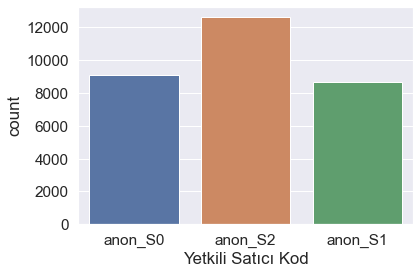

########################
unique value count: 2
Armatür, Aksesuar & Gömme Reze    16929
SSG & Tamamlayıcılar              13520
Name: Hiyerarşi 1, dtype: int64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


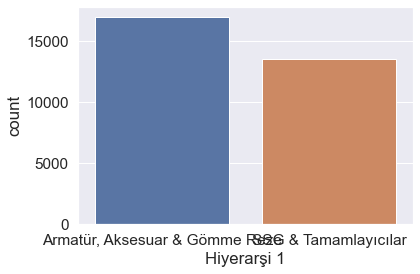

########################
unique value count: 3
Armatürler                  13659
Seramik Sağlık Gereçleri    13520
Gömme/Plastik Rezervuar      3270
Name: Hiyerarşi 2, dtype: int64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


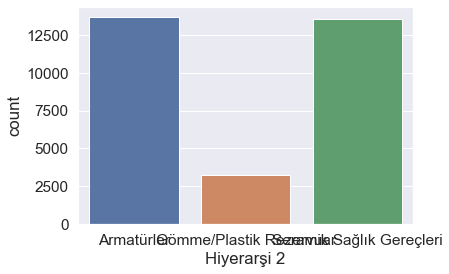

########################
unique value count: 3
A    13659
B    13520
C     3270
Name: URUN, dtype: int64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


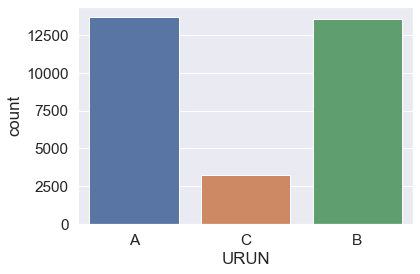

########################
unique value count: 4
Autumn    9052
Summer    8818
Spring    6925
Winter    5654
Name: SeasonName, dtype: int64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


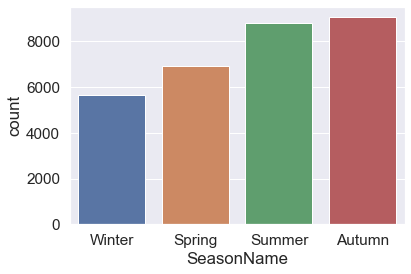

########################


In [292]:
for col in cat_cols:
    print("unique value count:", df[col].nunique())
    print(df[col].value_counts())
    print("########################")
    print(sns.countplot(x=df[col], data=df))
    plt.show()
    print("########################")

count     30449.000000
mean       3879.690018
std        7829.840045
min      -65408.400000
25%        1434.000000
50%        2448.300000
75%        4496.338800
max      478026.000000
Name: Net Fiyat_Sum, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


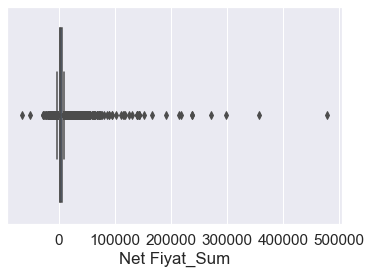

count    30449.000000
mean         1.478538
std          1.885659
min        -32.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        125.000000
Name: Adet_Sum, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


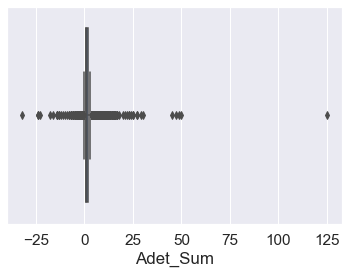

count    30449.000000
mean         6.690893
std          3.237940
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
max         12.000000
Name: New_month, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


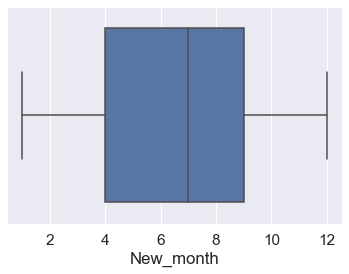

count    30449.000000
mean        17.638839
std          8.612302
min          1.000000
25%         10.000000
50%         18.000000
75%         25.000000
max         31.000000
Name: New_day, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


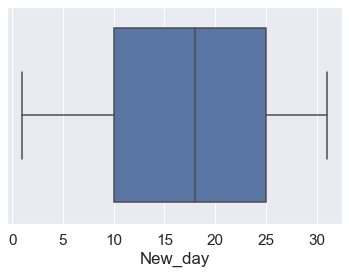

count    30446.00000
mean         5.92777
std          1.16790
min          3.74045
25%          5.30765
50%          5.82125
75%          6.84835
max          8.46890
Name: Dolar_Kur, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


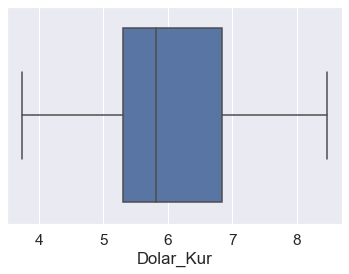

count    30449.000000
mean       112.507450
std         11.751897
min         81.557718
25%        103.932758
50%        112.946706
75%        123.443910
max        134.042934
Name: sale_index, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


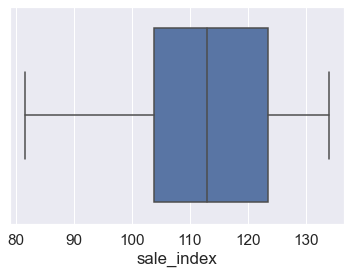

count    30449.000000
mean       419.549748
std         49.067604
min        330.750000
25%        390.840000
50%        422.840000
75%        465.840000
max        498.580000
Name: tufe_index, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


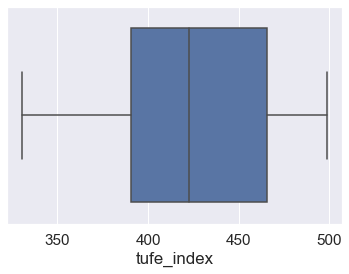

count    30449.000000
mean       444.137490
std         60.118687
min        319.600000
25%        422.940000
50%        451.310000
75%        485.370000
max        555.180000
Name: ufe_index, dtype: float64
########################
AxesSubplot(0.125,0.125;0.775x0.755)


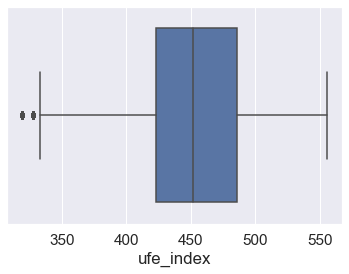

In [293]:
for col in num_cols:
    print(df[col].describe().T)
    print("########################")
    print(sns.boxplot(x=df[col]))
    plt.show()

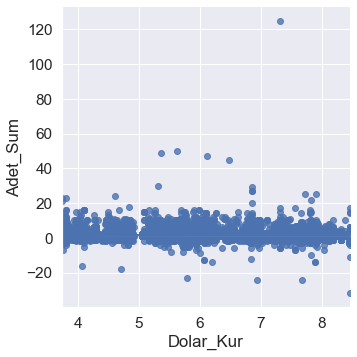

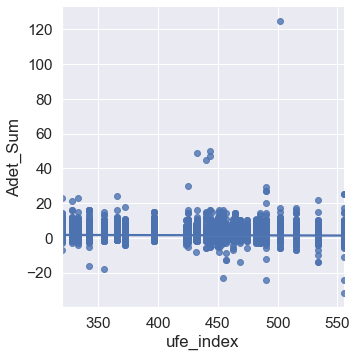

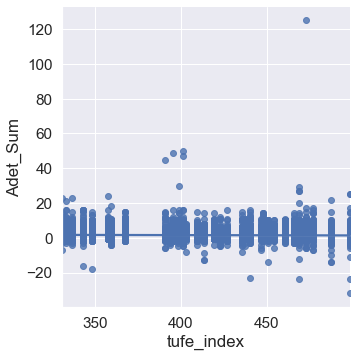

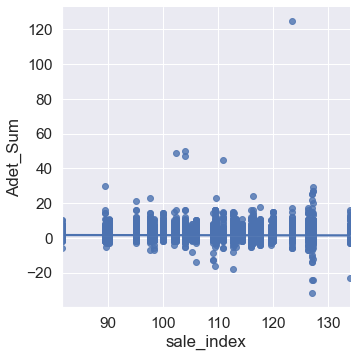

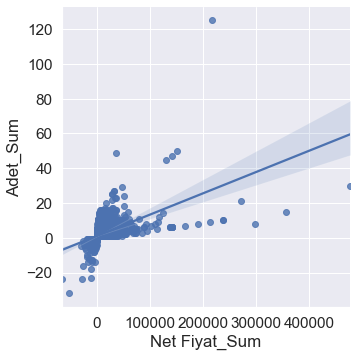

In [294]:
group = ["Dolar_Kur", "ufe_index", "tufe_index", "sale_index", "Net Fiyat_Sum"]
for col in group:
    sns.lmplot(x=col, y="Adet_Sum", data=df)

In [295]:
drop_list = df[(df["Adet_Sum"]<0) & (df["Net Fiyat_Sum"]>0)]
drop_list.index

Int64Index([49, 1494, 2437, 3485, 5253, 7859], dtype='int64')

In [296]:
drop_list2 = df[(df["Adet_Sum"]==0) & (df["Net Fiyat_Sum"]>0)]
drop_list2

,Yetkili Satıcı Kod,Müşteri Kod,MatbuNo,Hiyerarşi 1,Hiyerarşi 2,Net Fiyat_Sum,Adet_Sum,URUN,New_year,New_month,...,New_is_quarter_start,New_is_year_end,New_is_year_start,Season,SeasonName,Dolar_Kur,Gun_Tanm,sale_index,tufe_index,ufe_index
18101,anon_S1,120.01.G2039,GNY2019000005394,SSG & Tamamlayıcılar,Seramik Sağlık Gereçleri,234.0,0.0,B,2019,11,...,False,False,False,4,Autumn,5.74805,Regular Day,113.17404,437.25,450.97


In [297]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
train, test = train_test_split(df, test_size = 0.20, random_state = 42 )

In [298]:
len(train.columns)

25

In [299]:
test.columns

Index(['Yetkili Satıcı Kod', 'Müşteri Kod', 'MatbuNo', 'Hiyerarşi 1',
       'Hiyerarşi 2', 'Net Fiyat_Sum', 'Adet_Sum', 'URUN', 'New_year',
       'New_month', 'New_day', 'New_dayofweek', 'New_is_month_end',
       'New_is_month_start', 'New_is_quarter_end', 'New_is_quarter_start',
       'New_is_year_end', 'New_is_year_start', 'Season', 'SeasonName',
       'Dolar_Kur', 'Gun_Tanm', 'sale_index', 'tufe_index', 'ufe_index'],
      dtype='object')

In [300]:
test.columns == train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

### Missing Values & Outliers

In [301]:
train["Dolar_Kur"].fillna(train["Dolar_Kur"].median(), inplace=True)

In [302]:
test["Dolar_Kur"].fillna(train["Dolar_Kur"].median(), inplace=True)

In [303]:
def finding_outlier_thresolds(data, col_name):
    q1 = data[col_name].quantile(0.01)
    q3 = data[col_name].quantile(0.99)
    IQR = q3 - q1
    up = q3 + 3 * IQR
    low = q1 - 3 * IQR
    
    return up, low

In [304]:
train.columns

Index(['Yetkili Satıcı Kod', 'Müşteri Kod', 'MatbuNo', 'Hiyerarşi 1',
       'Hiyerarşi 2', 'Net Fiyat_Sum', 'Adet_Sum', 'URUN', 'New_year',
       'New_month', 'New_day', 'New_dayofweek', 'New_is_month_end',
       'New_is_month_start', 'New_is_quarter_end', 'New_is_quarter_start',
       'New_is_year_end', 'New_is_year_start', 'Season', 'SeasonName',
       'Dolar_Kur', 'Gun_Tanm', 'sale_index', 'tufe_index', 'ufe_index'],
      dtype='object')

In [305]:
for col in num_cols:
    print(col, "up, low:", finding_outlier_thresolds(train, col))

Net Fiyat_Sum up, low: (109134.02399999968, -88749.77399999977)
Adet_Sum up, low: (39.0, -31.0)
New_month up, low: (45.0, -32.0)
New_day up, low: (118.0, -85.0)
Dolar_Kur up, low: (21.985349999999997, -9.910499999999999)
sale_index up, low: (291.49858287892823, -75.89793027986865)
tufe_index up, low: (1002.0699999999999, -172.73999999999995)
ufe_index up, low: (1261.9199999999996, -387.13999999999976)


In [306]:
for col in num_cols:
    print(col, "up, low:", finding_outlier_thresolds(test, col))

Net Fiyat_Sum up, low: (107970.96899999998, -87940.94999999998)
Adet_Sum up, low: (39.0, -31.0)
New_month up, low: (45.0, -32.0)
New_day up, low: (118.0, -85.0)
Dolar_Kur up, low: (21.9825, -9.9067)
sale_index up, low: (291.49858287892823, -75.89793027986865)
tufe_index up, low: (1002.0699999999999, -172.73999999999995)
ufe_index up, low: (1261.9199999999996, -387.13999999999976)


In [307]:
def grab_outliers(data, col, outliers_index=True):
    up, low = finding_outlier_thresolds(data, col)
    outliers = data[(data[col] < low) | (data[col] > up)]
    return outliers

In [308]:
# train outliers tespiti
for col in num_cols:
    outliers = grab_outliers(train, col)
    print(col, "outliers:", outliers)
    print("############################")
    print(col, "number of outliers:", len(outliers))
    print("############################")

Net Fiyat_Sum outliers:       Yetkili Satıcı Kod   Müşteri Kod           MatbuNo  \
27477            anon_S0    120.05.183  OLC2020000008807   
27476            anon_S0    120.05.183  OLC2020000008804   
18795            anon_S0    120.05.183  OLC2019000006962   
30193            anon_S0    120.05.183  OLC2020000012139   
18035            anon_S0    120.05.183  OLC2019000006502   
11318            anon_S0    120.05.183  OLC2019000001023   
1270             anon_S0    120.05.183  OLC2018000000660   
22228            anon_S0    120.05.183  OLC2020000004254   
20293            anon_S0    120.05.183  OLC2020000001450   
13123            anon_S1  120.01.Y1545  GUN2019000004097   
23296            anon_S0    120.05.183  OLC2020000005388   
28912            anon_S0    120.05.183  OLC2020000010937   
15447            anon_S0    120.24.008  EO12019000008826   
7875             anon_S0    120.05.183  OLC2018000005484   
21137            anon_S0    120.05.183  OLC2020000003124   
7876            

In [309]:
# test outliers tespiti
for col in num_cols:
    outliers = grab_outliers(test, col)
    print(col, "outliers:", outliers)
    print("############################")
    print(col, "number of outliers:", len(outliers))
    print("############################")

Net Fiyat_Sum outliers:       Yetkili Satıcı Kod      Müşteri Kod           MatbuNo  \
24551            anon_S0       120.05.183  OLC2020000006540   
20294            anon_S0       120.05.183  OLC2020000002092   
25624            anon_S0       120.05.183  OLC2020000008398   
21681            anon_S0       120.05.183  OLC2020000003678   
11958            anon_S2  120.SB.LARA0272  AR82019000001329   
21682            anon_S0       120.05.183  OLC2020000003875   

                          Hiyerarşi 1               Hiyerarşi 2  \
24551            SSG & Tamamlayıcılar  Seramik Sağlık Gereçleri   
20294            SSG & Tamamlayıcılar  Seramik Sağlık Gereçleri   
25624  Armatür, Aksesuar & Gömme Reze   Gömme/Plastik Rezervuar   
21681            SSG & Tamamlayıcılar  Seramik Sağlık Gereçleri   
11958            SSG & Tamamlayıcılar  Seramik Sağlık Gereçleri   
21682            SSG & Tamamlayıcılar  Seramik Sağlık Gereçleri   

       Net Fiyat_Sum  Adet_Sum URUN  New_year  New_month  ...  \

In [310]:
# her iki gruptaki outliers da train sınırlarına uygun olarak doldurulacak
def replace_outliers(df,col):
    up, low = finding_outlier_thresolds(train, col)
    df[(df[col] < low)] = low          
    df[(df[col] > up)] = up

In [311]:
group = ["Dolar_Kur", "ufe_index", "tufe_index", "sale_index", "Net Fiyat_Sum"]
for col in group:
    replace_outliers(train, col)

In [312]:
for col in group:
    replace_outliers(test, col)

In [313]:
# baskılama yönteminden sonra kalan outlier var mı?
for col in num_cols:
    outliers = grab_outliers(train, col)
    print(col, "outliers:", outliers)
    print("############################")
    print(col, "number of outliers:", len(outliers))
    print("############################")

Net Fiyat_Sum outliers: Empty DataFrame
Columns: [Yetkili Satıcı Kod, Müşteri Kod, MatbuNo, Hiyerarşi 1, Hiyerarşi 2, Net Fiyat_Sum, Adet_Sum, URUN, New_year, New_month, New_day, New_dayofweek, New_is_month_end, New_is_month_start, New_is_quarter_end, New_is_quarter_start, New_is_year_end, New_is_year_start, Season, SeasonName, Dolar_Kur, Gun_Tanm, sale_index, tufe_index, ufe_index]
Index: []

[0 rows x 25 columns]
############################
Net Fiyat_Sum number of outliers: 0
############################
Adet_Sum outliers:       Yetkili Satıcı Kod Müşteri Kod           MatbuNo  \
27477             109134      109134            109134   
27476             109134      109134            109134   
18795             109134      109134            109134   
30193             109134      109134            109134   
18035             109134      109134            109134   
11318             109134      109134            109134   
1270              109134      109134            109134   
2222

In [314]:
for col in num_cols:
    outliers = grab_outliers(test, col)
    print(col, "outliers:", outliers)
    print("############################")
    print(col, "number of outliers:", len(outliers))
    print("############################")

Net Fiyat_Sum outliers:       Yetkili Satıcı Kod Müşteri Kod MatbuNo Hiyerarşi 1 Hiyerarşi 2  \
24551             109134      109134  109134      109134      109134   
20294             109134      109134  109134      109134      109134   
25624             109134      109134  109134      109134      109134   
21681             109134      109134  109134      109134      109134   
11958             109134      109134  109134      109134      109134   
21682             109134      109134  109134      109134      109134   

       Net Fiyat_Sum    Adet_Sum    URUN    New_year   New_month  ...  \
24551     109134.024  109134.024  109134  109134.024  109134.024  ...   
20294     109134.024  109134.024  109134  109134.024  109134.024  ...   
25624     109134.024  109134.024  109134  109134.024  109134.024  ...   
21681     109134.024  109134.024  109134  109134.024  109134.024  ...   
11958     109134.024  109134.024  109134  109134.024  109134.024  ...   
21682     109134.024  109134.024 

In [315]:
train.drop(["Müşteri Kod", 'MatbuNo'], axis=1, inplace=True)

test.drop(["Müşteri Kod", 'MatbuNo'], axis=1, inplace=True)

In [316]:
train = pd.get_dummies(train)

test = pd.get_dummies(test)

In [317]:
train, test = train.align(test, join='left', axis=1)

In [318]:
train.head()

,Net Fiyat_Sum,Adet_Sum,New_year,New_month,New_day,New_dayofweek,Season,Dolar_Kur,sale_index,tufe_index,...,Gun_Tanm_30 Ağustos Zafer Bayramı,Gun_Tanm_31 Aralık Yılbaşı gecesi,Gun_Tanm_Kurban Bayramı 1. Gün,Gun_Tanm_Kurban Bayramı 2. Gün,Gun_Tanm_Kurban Bayramı 4. Gün,Gun_Tanm_Kurban Bayramı Arefe,Gun_Tanm_Ramazan Bayrami Arefe,Gun_Tanm_Ramazan Bayramı resmi tatil edildi(Cuma),Gun_Tanm_Ramazan Bayramı resmi tatil edildi(Pazartesi),Gun_Tanm_Regular Day
9507,1227.600,1.0,2018.0,11.0,23.0,4.0,4.0,5.30765,102.348535,395.48,...,0,0,0,0,0,0,0,0,0,1
9570,1731.600,1.0,2018.0,12.0,24.0,0.0,1.0,5.27935,119.706647,393.88,...,0,0,0,0,0,0,0,0,0,1
26352,4129.188,1.0,2020.0,9.0,11.0,4.0,4.0,7.46205,126.347845,477.21,...,0,0,0,0,0,0,0,0,0,1
22657,5608.800,1.0,2020.0,6.0,8.0,0.0,3.0,6.76340,116.292680,465.84,...,0,0,0,0,0,0,0,0,0,1
3860,1760.400,1.0,2018.0,5.0,8.0,1.0,2.0,4.25965,112.714014,348.34,...,0,0,0,0,0,0,0,0,0,1


In [321]:
train.head()

,Net Fiyat_Sum,Adet_Sum,New_year,New_month,New_day,New_dayofweek,Season,Dolar_Kur,sale_index,tufe_index,...,Gun_Tanm_30 Ağustos Zafer Bayramı,Gun_Tanm_31 Aralık Yılbaşı gecesi,Gun_Tanm_Kurban Bayramı 1. Gün,Gun_Tanm_Kurban Bayramı 2. Gün,Gun_Tanm_Kurban Bayramı 4. Gün,Gun_Tanm_Kurban Bayramı Arefe,Gun_Tanm_Ramazan Bayrami Arefe,Gun_Tanm_Ramazan Bayramı resmi tatil edildi(Cuma),Gun_Tanm_Ramazan Bayramı resmi tatil edildi(Pazartesi),Gun_Tanm_Regular Day
9507,1227.600,1.0,2018.0,11.0,23.0,4.0,4.0,5.30765,102.348535,395.48,...,0,0,0,0,0,0,0,0,0,1
9570,1731.600,1.0,2018.0,12.0,24.0,0.0,1.0,5.27935,119.706647,393.88,...,0,0,0,0,0,0,0,0,0,1
26352,4129.188,1.0,2020.0,9.0,11.0,4.0,4.0,7.46205,126.347845,477.21,...,0,0,0,0,0,0,0,0,0,1
22657,5608.800,1.0,2020.0,6.0,8.0,0.0,3.0,6.76340,116.292680,465.84,...,0,0,0,0,0,0,0,0,0,1
3860,1760.400,1.0,2018.0,5.0,8.0,1.0,2.0,4.25965,112.714014,348.34,...,0,0,0,0,0,0,0,0,0,1


In [322]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
### Modeling

In [ ]:
def cooef_variation(rmse, target):
    cv = (rmse/(df[target].sum()/len(df[target])))
    if cv<1:
        print("cv utophic")
    elif 1<cv<5:
        print("cv very good")
    elif 5<cv<10:
        print("cv good")
    elif 10<cv<15:
        print("cv moderate")
    elif 15<cv<20:
        print("cv low")
    elif 20<cv<25:
        print("cv very low")
    elif 25<cv:
        print("cv catastrophic")
    return cv

In [ ]:
X = train.drop("Adet_Sum", axis=1)
y = train["Adet_Sum"]

In [ ]:
X_test = test.drop("Adet_Sum", axis=1)
y_test = test["Adet_Sum"]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lm = LinearRegression()
model = lm.fit(X, y)

In [ ]:
cross_val_score(model, X, y, cv = 10, scoring = "r2").mean()

In [ ]:
cross_val_score(model, X_test, y_test, cv = 10, scoring = "r2").mean()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse

In [ ]:
cv = cooef_variation(rmse, "Adet_Sum")
cv

In [ ]:
r2_score(y_test, model.predict(X_test))

In [ ]:
model.score(X_test, y_test)

In [ ]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha = 0.1).fit(X, y)
ridge_model
ridge_model.coef_

In [ ]:
cross_val_score(ridge_model, X, y, cv = 10, scoring = "r2").mean()

In [ ]:
cross_val_score(ridge_model, X_test, y_test, cv = 10, scoring = "r2").mean()

In [ ]:
lambdalar = 10**np.linspace(10, -2, 100)*0.5 #soru1 :neye göre bu değerler?

In [ ]:
ridge_model = Ridge() # soru2: bu döngüyü bir grafik elde etmek için yapıyoruz fakat bu grafik gerçekten gerekli mi??
katsayilar = []
for i in lambdalar:
    ridge_model.set_params(alpha = i)
    ridge_model.fit(X, y)
    katsayilar.append(ridge_model.coef_)

In [ ]:
ax = plt.gca()
ax.plot(lambdalar, katsayilar)
ax.set_xscale("log")

In [ ]:
plt.xlabel("lambda(alpha) değerleri")
plt.ylabel("katsayilar/ağirliklar")
plt.title("düzenlileştiemnin bir fonksiyonu olarak ridge katsayıları")

In [ ]:
y_pred = ridge_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv = cooef_variation(rmse, "Adet_Sum")
cv

In [ ]:
cross_val_score(ridge_model, X_test, y_test, cv = 10, scoring = "r2").mean()

In [ ]:
rmse

In [ ]:
lambdalar = 10**np.linspace(10, -2, 100)*0.5
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas = lambdalar, scoring = "neg_mean_squared_error", normalize = True)
ridge_cv.fit(X, y)
ridge_cv.alpha_

In [ ]:
ridge_tuned = Ridge(alpha = ridge_cv.alpha_, normalize = True).fit(X, y)
y_pred = ridge_tuned.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv = cooef_variation(rmse, "Adet_Sum")
cv

In [ ]:
cross_val_score(ridge_tuned, X, y, cv = 10, scoring = "r2").mean()

In [ ]:
cross_val_score(ridge_tuned, X_test, y_test, cv = 10, scoring = "r2").mean()

In [ ]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]


for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    cv = cooef_variation(rmse, "Adet_Sum")
    r2 = cross_val_score(regressor, X, y, cv = 10, scoring = "r2").mean()
    print(f"RMSE: {round(rmse, 4)} ({name}) ")
    print(f"cv: {cv}")
    print("r2:", r2)

In [ ]:
### XGBM

xgb_model = XGBRegressor().fit(X, y)
y_pred = xgb_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
cross_val_score(xgb_model, X_test, y_test, cv = 10, scoring = "r2").mean()

In [ ]:
#model tuning
xgb_grid = {"colsample_bytree": [0.4,1],
            "n_estimators": [100, 500],
            "max_depth": [2,3,5],
            "learning_rate": [0.01, 0.1, 0.5]}
from sklearn.model_selection import GridSearchCV
xgb_cv = GridSearchCV(xgb_model, xgb_grid, cv = 5, n_jobs = -1, verbose = 2)
xgb_cv.fit(X, y)

In [ ]:
xgb_cv.best_params_

In [ ]:
xgb_tuned = XGBRegressor(colsample_bytree = 0.4, learning_rate = 0.01, max_depth = 5, n_estimators = 1000).fit(X, y)
y_pred = xgb_tuned.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
cross_val_score(xgb_tuned, X_test, y_test, cv = 10, scoring = "r2").mean()

In [ ]:
feature_imp = pd.DataFrame({'Value': xgb_tuned.feature_importances_, 'Feature': X.columns})
feature_imp.sort_values(by="Value", ascending=False)

In [ ]:
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:10])

In [ ]:
zero_imp_cols = feature_imp[feature_imp["Value"] < 0.001]["Feature"].values
selected_cols = [col for col in X.columns if col not in zero_imp_cols]
selected_cols

In [ ]:
xgb_tuned = xgb_tuned.fit(X[selected_cols], y)
y_pred = xgb_tuned.predict(X_test[selected_cols])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv = cooef_variation(rmse, "Adet_Sum")
cv

In [ ]:
cross_val_score(xgb_tuned, X_test[selected_cols], y_test, cv = 10, scoring = "r2").mean()

In [ ]:
rmse = np.mean(np.sqrt(-cross_val_score(xgb_tuned, X_test[selected_cols], y_test, cv=10, scoring="neg_mean_squared_error")))
cv = cooef_variation(rmse, "Adet_Sum")
cv